In [1]:
import torch.nn.functional as F
import torch
from torch import Tensor
from torchvision.transforms.functional import crop, resize

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib
import numpy as np
from PIL import Image

from pathlib import Path

In [2]:
import PIL

In [3]:
from cfa import sparse_ones, rgb_to_cfa, colorize_cfa

In [4]:
import os
#mpl.use('pgf')
plt.style.use("seaborn-v0_8-darkgrid")
#plt.rcParams['font.family'] = 'monospace'

def findAllFiles(path):
    res = []
    path, folders, files = next(os.walk(path))
    if folders:
        for f in folders:
            res.extend(findAllFiles(os.path.join(path, f)))
    res.extend([os.path.join(path, f) for f in files if not f.endswith(".txt")])
    return res

def read_loss_file(path):
    with open(path, "r") as f:
        return np.array([float(line.strip()) for line in f.readlines()])

def read_loss_files(path, format, noise, intensity, i=5):
    return np.array([read_loss_file(path / f"{format}{noise.lower()}{intensity}_{n}-val-loss.txt") for n in range(i)])

In [5]:
raw_folder = "../../raw-instinct/16bitRAW"
classes    = os.listdir(raw_folder)
raw_data   = [(c,[np.load(f).astype(np.int32)
                  for f in findAllFiles(os.path.join(raw_folder, c))]) 
              for c in classes]

### Chrominance visualisation

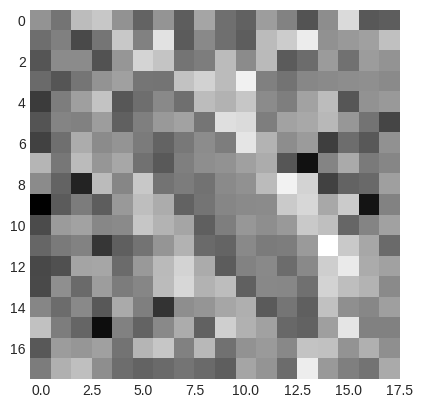

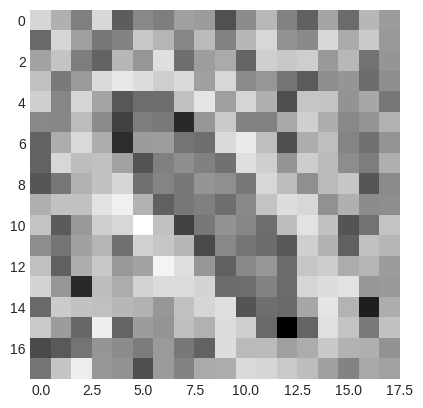

0.5007947087287903 0.3890971839427948


In [6]:
def chroma(mat):
    bayer_k = Tensor(sparse_ones((4,1,2,2), [(0,0,0,1),(1,0,0,0),(2,0,1,0),(3,0,1,1)]))
    rgb_k   = Tensor(sparse_ones((4,3,2,2), [(0,0,0,1),(1,1,0,0),(2,2,1,0),(3,1,1,1)]))
    cr_k    = Tensor(sparse_ones((2,3,2,2), [(1,1,1,0),(0,0,1,0)]))
    cb_k    = Tensor(sparse_ones((2,3,2,2), [(1,1,0,1),(0,2,0,1)]))
    g_int_k = Tensor(sparse_ones((3,3,3,3), [(1,1,0,1),(1,1,1,0),(1,1,1,2),(1,1,2,1)]) * 0.25)
    
    tensor = torch.Tensor(mat).unsqueeze(0)
    
    # CFA 1d -> RGB CFA 3d representation
    conv   = F.conv2d(          tensor, stride=2, weight=bayer_k, padding=1)
    rgb    = F.conv_transpose2d(conv,   stride=2, weight=rgb_k,   padding=1)

    # Interpolate green channel
    bi_g   = F.conv2d(          rgb,              weight=g_int_k, padding=1) + rgb

    # Extract green/red and green/blue
    cr_l   = F.conv2d(          bi_g,   stride=2, weight=cr_k)
    cb_l   = F.conv2d(          bi_g,   stride=2, weight=cb_k)

    c, h, w   = cr_l.shape

    # Calculate chrominance as two maps
    cr     = crop(cr_l[0] / cr_l[1], 1, 1, h-2, w-2)
    cb     = crop(cb_l[0] / cb_l[1], 1, 1, h-2, w-2)

    return cr, cb
    

def chromaMean(mat):
    cr, cb = chroma(mat)
    return torch.mean(cr).item(), torch.mean(cb).item()

# Did not find anything interesting
def chroma90thPercentile(mat):
    cr, cb = chroma(mat)
    return (
        np.percentile(cr.numpy(), 90),
        np.percentile(cb.numpy(), 90)
    )


test = raw_data[0][1][0]

cr, cb = chroma(test)

plt.style.use("seaborn-v0_8-dark")
plt.imshow((cr / cr.max()))
plt.show()
plt.imshow((cb / cb.max()))
plt.show()
print(torch.mean(cr).item(), torch.mean(cb).item())

In [7]:
raw_chroma = [(c, np.array([chromaMean(m) for m in lst])) for (c, lst) in raw_data]

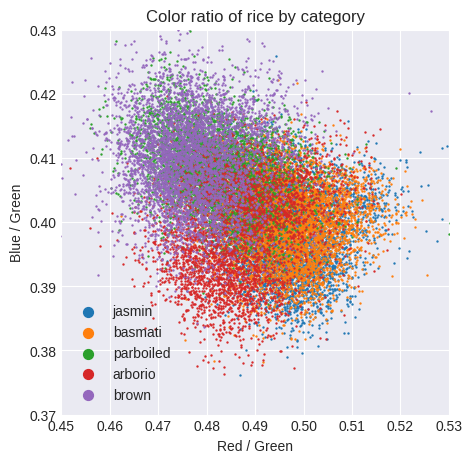

In [8]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("Color ratio of rice by category")
ax.set_ylim([0.37, 0.43])
ax.set_xlim([0.45,  0.53])
ax.set_xlabel("Red / Green")
ax.set_ylabel("Blue / Green")
for (c, lst) in raw_chroma:
    ax.scatter(*lst.T, s=0.5, label=c)

ax.legend(markerscale=10)

### Value visualisation
Notice that the Arborio rice seperate out from the rest.

In [9]:
raw_min_maxs = [(c, np.array([[np.percentile(np.array(m), 10), 
                               np.percentile(np.array(m), 90)] for m in lst])) for (c, lst) in raw_data]

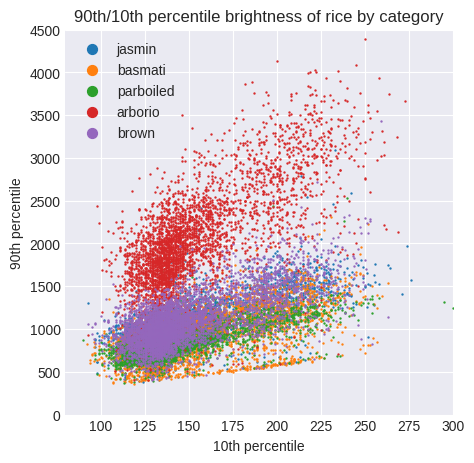

In [10]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("90th/10th percentile brightness of rice by category")
ax.set_ylim([0, 4500])
ax.set_xlim([80, 300])
ax.set_xlabel("10th percentile")
ax.set_ylabel("90th percentile")
for (c, lst) in raw_min_maxs:
    ax.scatter(*lst.T, s=0.5, label=c)

ax.legend(markerscale=10)

In [11]:
mean_min_maxs = [(c, np.array([[np.mean(np.array(m)[0:12,0:12]), 
                                np.mean(np.array(m)[10:30, 10:30])] for m in lst])) for (c, lst) in raw_data]

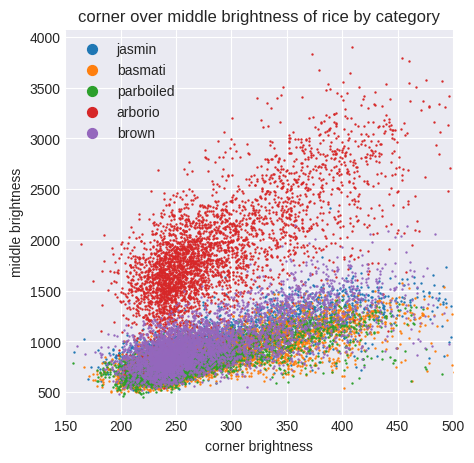

In [12]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("corner over middle brightness of rice by category")
#ax.set_ylim([0, 4500])
ax.set_xlim([150, 500])
ax.set_xlabel("corner brightness")
ax.set_ylabel("middle brightness")
for (c, lst) in mean_min_maxs:
    ax.scatter(*lst.T, s=0.5, label=c)

ax.legend(markerscale=10)

### DNG dataset packing 

In [13]:
import math
import dng

flatten = lambda matrix: [item for row in matrix for item in row]

dataset     = raw_data
layout      = [(c, len(imgs)) for (c, imgs) in raw_data]
imgs        = flatten([imgs for (_, imgs) in dataset])
n_cells     = sum([l for (_, l) in layout])
cell_shape  = (40,40)
padding     = (12,12)
cell_w      = (padding[1]*2 + cell_shape[1])
dng_cells_w = math.ceil(math.sqrt(len(imgs)))
dng_px_w    = dng_cells_w * cell_w

res = np.zeros((dng_px_w, dng_px_w), dtype=np.uint16)

for n, img in enumerate(imgs):
    x = ((n % dng_cells_w)  * cell_w) + padding[0]
    y = ((n // dng_cells_w) * cell_w) + padding[1]
    res[x:x+cell_shape[0], y:y+cell_shape[1]] = img * (2**15 / img.max())

#dng.saveFile(res, "test_dng/rice")

In [14]:
from pidng.core import RAW2DNG, DNGTags, Tag
from pidng.defs import *
import os

# Test Colour Correction Matrix - 1
ccm1 = [[10000,10000], [10000,10000], [10000,10000],
        [10000,10000], [10000,10000], [10000,10000],
        [10000,10000], [10000,10000], [10000,10000]]

# Test Colour Correction Matrix - 2
# leads to errors
ccm2 = [[0,1], [0,1], [0,1],
        [0,1], [0,1], [0,1],
        [0,1], [0,1], [0,1]]

def saveFile(cfa_img, filename, bpp = 16):
    height, width = cfa_img.shape

    # set DNG tags.
    t = DNGTags()
    #t.set(Tag.ColorMatrix1, ccm1) # colour correction matrix

    t.set(Tag.ImageWidth, width)
    t.set(Tag.ImageLength, height)
    #t.set(Tag.TileWidth, width) # Not supported?
    #t.set(Tag.TileLength, height) # Not supported?
    t.set(Tag.Orientation, Orientation.Horizontal)
    t.set(Tag.PhotometricInterpretation, PhotometricInterpretation.Color_Filter_Array)
    t.set(Tag.SamplesPerPixel, 1)
    t.set(Tag.BitsPerSample, bpp)
    t.set(Tag.CFARepeatPatternDim, [2,2])
    t.set(Tag.CFAPattern, CFAPattern.GBRG)
    #t.set(Tag.BlackLevel, (4096 >> (16 - bpp))) # def. 0
    #t.set(Tag.WhiteLevel, ((1 << bpp) -1)) # def. 2^bpp -1
    
    #t.set(Tag.CalibrationIlluminant1, CalibrationIlluminant.D65) # def. unknown
    t.set(Tag.AsShotNeutral, [[1,1],[1,1],[1,1]]) # RGB white
    #t.set(Tag.BaselineExposure, [[1, 0]]) # Exposure compensation, defualt 0, repr. 0/1?
    
    t.set(Tag.Make, "No camera - Synthetically generated")
    t.set(Tag.Model, "v1")
    t.set(Tag.DNGVersion, DNGVersion.V1_4)
    t.set(Tag.DNGBackwardVersion, DNGVersion.V1_2)
    t.set(Tag.PreviewColorSpace, PreviewColorSpace.sRGB)

    # save to dng file.
    r = RAW2DNG()
    r.options(t, path="", compress=False) # Enabling compression crashes Jupyter
    r.convert(cfa_img, filename=filename)

for i, img in enumerate(imgs[:3]):
    res = np.ones((230, 230))
    res[95:135, 95:135] = img * (2**15 / img.max())
    print(res.shape)
    saveFile(np.array(res, dtype=np.uint16), f"rice_{i}")

#os.system("rawtherapee-cli -tz -Y -c rice_1.dng rice_2.dng")
os.system("ls")

(230, 230)
(230, 230)
(230, 230)
cfa.py
dataset-exploration.ipynb
demosaic.sh
denoisingunet.py
dng.py
ds_99th.py
ds_augment.py
ds_convert.py
ds_distance.py
im_prep.ipynb
noise.py
pidng
__pycache__
rand100k.npy
rice_0.dng
rice_1.dng
rice_2.dng
torch-unet.ipynb
train.py
unknown.png
validate.py


0

#### Color test image

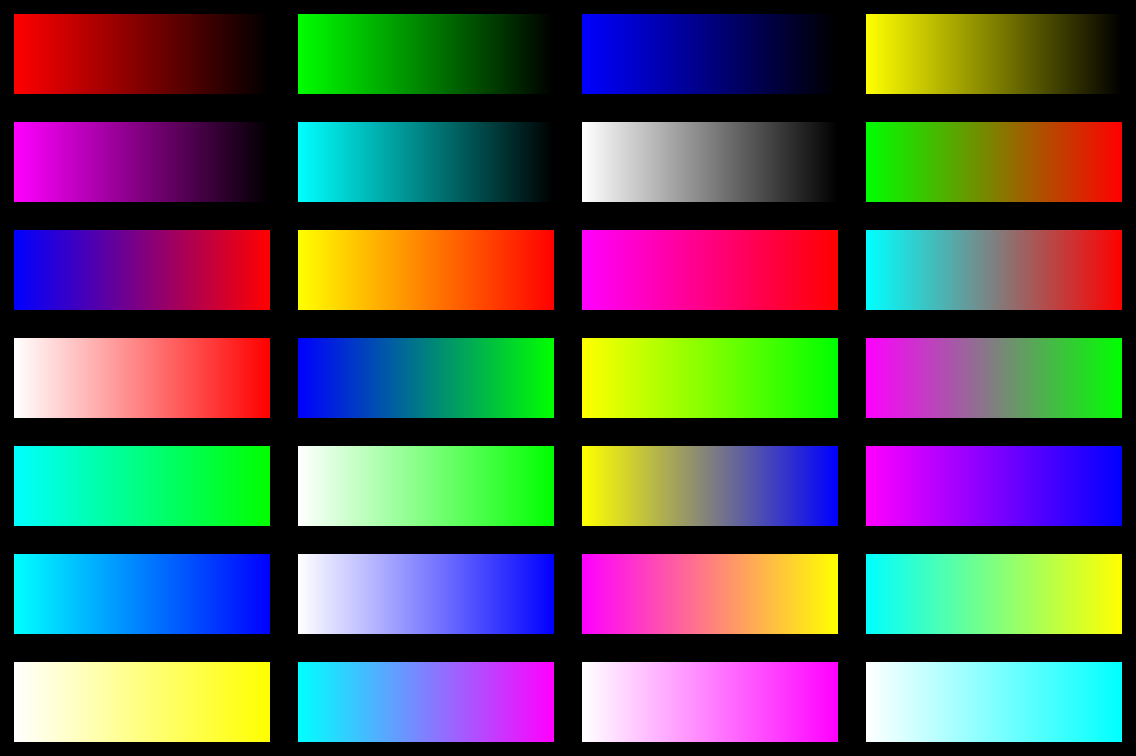

In [15]:
from itertools import chain, combinations, product

# From itertools documentation
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

sweeps = list(combinations(powerset([0,1,2]), 2))

grey   = np.array([128,128,128])

dtype, dt_max, dt_range = np.uint16, 2**16 - 1, 256

pad    = (14,14)
size   = (80, 256)
y_step = pad[1] * 2 + size[1]
x_step = pad[0] * 2 + size[0]

ct_arr = np.zeros((x_step, y_step * len(sweeps), 3), dtype=dtype)

sweep_in  = np.pad(np.broadcast_to(np.linspace(0, dt_max, size[1], dtype=dtype), size), pad)
sweep_out = np.pad(np.broadcast_to(np.linspace(dt_max, 0, size[1], dtype=dtype), size), pad)

for i, (sweep_from, sweep_to) in enumerate(sweeps):
    for c in sweep_from:
        ct_arr[:, i*y_step:(i+1)*y_step, c] += sweep_in
    for c in sweep_to:
        ct_arr[:, i*y_step:(i+1)*y_step, c] += sweep_out

ct_img = np.zeros((x_step * 7, y_step * 4, 3), dtype=dtype)

for i in range(7):
    for j in range(4):
        n = i*4 + j
        ct_img[i*x_step:(i+1)*x_step, j*y_step:(j+1)*y_step] = ct_arr[:, n*y_step:(n+1)*y_step]
    
        
display(Image.fromarray(np.array(ct_img, dtype=np.uint8)))

#### DNG Roundtrip convertion loss

In [16]:
rgb_kf  = sparse_ones((3,2,2), [(0,0,1),(1,0,0),(2,1,0),(1,1,1)])

dng.saveFile(rgb_to_cfa(ct_img, rgb_kf), "ct")

AttributeError: module 'dng' has no attribute 'saveFile'

In [ ]:
img_ct_roundtrip = np.array(Image.open("ct-ahd-3step-color-supress.png"), dtype=np.uint16)

img_ct_diff = (ct_img - img_ct_roundtrip)
display(Image.fromarray((np.abs(img_ct_diff)).astype("uint8")))

#### Noise

In [ ]:
import torch
#from noise import salt_pepper_noise, salt_pepper_noise_torch

img = torch.tensor(np.array(ct_img, dtype=np.uint8), dtype=torch.float16).permute(2,0,1)

def torch_type_helper(tensor):
    if torch.is_floating_point(tensor):
        return torch.finfo, torch.float64
    elif not torch.is_complex(tensor):
        return torch.iinfo, torch.int64
    else:
        raise "Not float or int"

def gaussian_noise_torch(img, bias=.0, std=.1, input_scale=1, seed=[1,2,3], device="cpu"):
    info, double_type = torch_type_helper(img)
        
    c, h, w = img.shape
    d_max   = info(img.dtype).max

    gen     = torch.Generator(device=device)
    noise   = torch.normal(bias * d_max, std * d_max, (h, w), generator=gen).expand(c, h, w)

    res = input_scale * img.to(double_type) + noise.to(double_type)

    return np.clip(res, 0, d_max).to(img.dtype)

def salt_pepper_noise_torch(img, density=.3, sp_ratio=.5, seed=[1,2,3], device="cpu"):
    info, double_type = torch_type_helper(img)
    
    c, h, w = img.shape
    d_max   = info(img.dtype).max

    n_speckles = w*h*density
    n_salt     = int(n_speckles*sp_ratio)
    n_pepper   = int(n_speckles*(1-sp_ratio))

    gen = torch.Generator(device=device)

    def rand_coords(n):
        unique_rand = torch.randperm(h*w, generator=gen)[:n]
        return [(x % h, x // h) for x in unique_rand]

    res = img.clone()

    for x, y in rand_coords(n_salt):
        res[:, x, y] = d_max

    for x, y in rand_coords(n_pepper):
        res[:, x, y] = 0

    return res

display(Image.fromarray(np.array(gaussian_noise_torch(img, std=.4).permute(1,2,0), dtype=np.uint8)))
display(Image.fromarray(np.array(salt_pepper_noise_torch(img).permute(1,2,0), dtype=np.uint8)))

In [ ]:
from noise import gaussian_noise

display(Image.fromarray(gaussian_noise(np.array(ct_img, dtype=np.uint8))))

In [ ]:
from pathlib     import Path
from itertools   import product, combinations
from scipy.stats import mannwhitneyu, norm

formats     = ["npy", "ahdnogamma", "png", "ahdcc0"]
noises      = ["gaussian", "speckle", "saltpepper"]
intensities = [
    '64', '32', '16', '8',
    '4', '2', '1', '0.5',
    '0.25', '0.125', '0.0625'
]
loss_path   = Path("/home/gustav/Downloads/ds_proc/loss-multi")

def read_loss_file(path):
    with open(path, "r") as f:
        return np.array([float(line.strip()) for line in f.readlines()])

def read_loss_files(path, format, noise, intensity, i=5):
    return np.array([read_loss_file(path / f"{format}{noise}{intensity}_{n}-val-loss.txt") for n in range(i)])

for (noise, intensity) in product(noises, intensities):
    print()
    for combi in [combi for combi in combinations(formats, 2)][:1]:
        type1, type2 = combi
        losses1, losses2 = [read_loss_files(loss_path, format, noise, intensity) for format in combi]
        loss1, loss2     = losses1.mean(axis=1), losses2.mean(axis=1)
        ttest = mannwhitneyu(loss1, loss2)
        pval  = ttest.pvalue
        tstat = abs(ttest.statistic)
        print(f"{type1:10}: {loss1.mean():.4f} {type2:10}: {loss2.mean():.4f} {noise:10} {intensity:7} sig:{pval < 0.05:1} pval:{pval:.4f}")

In [ ]:
from pathlib     import Path
from itertools   import product, combinations
from scipy.stats import mannwhitneyu, norm

formats     = ["npy", "ahd", "png"]
noises      = ["gaussian", "speckle", "saltpepper"]
intensities = [f"{i}" for i in range(10,100,10)]
loss_path   = Path("/home/gustav/Downloads/ds_proc/loss-shuffle")

def read_loss_file(path):
    with open(path, "r") as f:
        return np.array([float(line.strip()) for line in f.readlines()])

def read_loss_files(path, format, noise, intensity, i=5):
    return np.array([read_loss_file(path / f"{format}{noise}{intensity}-val-loss.txt") for n in [0]])

for (noise, intensity) in product(noises, intensities):
    print()
    for combi in [combi for combi in combinations(formats, 2)][:1]:
        type1, type2 = combi
        loss1, loss2 = [read_loss_file(loss_path / f"{format}{noise}{intensity}-val-loss.txt") for format in combi]
        ttest = ttest_ind(loss1, loss2, equal_var=False)
        pval  = ttest.pvalue
        tstat = abs(ttest.statistic)
        print(f"{type1:3}: {loss1.mean():.4f} {type2:3}: {loss2.mean():.4f} {noise:10} {intensity:4} sig:{pval < 0.05:1} pval:{pval:.4f} t_test():{t_test(loss1, loss2)}")


In [22]:
from pathlib     import Path
from itertools   import product, combinations
from scipy.stats import ttest_ind, norm
from functools import lru_cache

formats     = ["npy", "ahd", "png"]
noises      = ["gaussian", "speckle", "saltpepper"]
intensities = ["10", "30", "70"]
loss_path   = Path("/home/gustav/Downloads/ds_proc/loss-shuffle")

@lru_cache(maxsize=128)
def read_loss_file(path):
    with open(path, "r") as f:
        return np.array([float(line.strip()) for line in f.readlines()])

def t_test(x1, x2):
    tval = (
        abs(x1.mean() + x2.mean()) 
        / ( (np.std(x1)**2 / len(x1))
           +(np.std(x1)**2 / len(x1)))
    )
    return tval > 1.96

for (noise, intensity) in product(noises, intensities):
    print()
    for combi in combinations(formats, 2):
        type1, type2 = combi
        loss1, loss2 = [read_loss_file(loss_path / f"{format}{noise}{intensity}-val-loss.txt") for format in combi]
        ttest = ttest_ind(loss1, loss2, equal_var=False)
        pval  = ttest.pvalue
        tstat = abs(ttest.statistic)
        print(f"{type1:3}: {loss1.mean():.4f} {type2:3}: {loss2.mean():.4f} {noise:10} {intensity:4} sig:{pval < 0.05:1} pval:{pval:.4f} t_test():{t_test(loss1, loss2)}")

bins=[i * 0.0003 for i in range(41)]
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,4), layout="constrained")

name_map = {
    "saltpepper": "Salt-and-Pepper",
    "gaussian": "Gaussian",
    "speckle": "Speckle"
}

for n, (noise, intensity) in enumerate(list(product(noises, intensities))):
    for format in formats:
        loss = read_loss_file(loss_path / f"{format}{noise}{intensity}-val-loss.txt")
        ax.flat[n].hist(loss, alpha=.6, bins=bins)
        #ax.flat[n].axis("off")
        ax.flat[n].set_ylim((0,14.9))
        ax.flat[n].set_title(f"{name_map[noise]} {intensity}%")
    plt.legend(formats)
fig.supxlabel("MSRE")
fig.supylabel("count")
plt.show()

bins = np.array([i * 0.0006 for i in range(41)])
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(10,4))

for n, (noise, intensity) in enumerate(list(product(noises, intensities))):
    for format in formats:
        loss = read_loss_file(loss_path / f"{format}{noise}{intensity}-val-loss.txt")
        mu, std = norm.fit(loss)
        p = norm.pdf(bins, mu, std)
        #ax.flat[n].hist(loss, bins=bins, alpha=.6)
        ax.flat[n].plot(p)
        ax.flat[n].set_ylim((0,500))
        ax.flat[n].set_title(f"{noise} {intensity}%")
    plt.legend(formats)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/gustav/Downloads/ds_proc/loss-shuffle/npygaussian10-val-loss.txt'

FileNotFoundError: [Errno 2] No such file or directory: '/home/gustav/Downloads/ds_proc/loss-shuffle/npygaussian10-val-loss.txt'

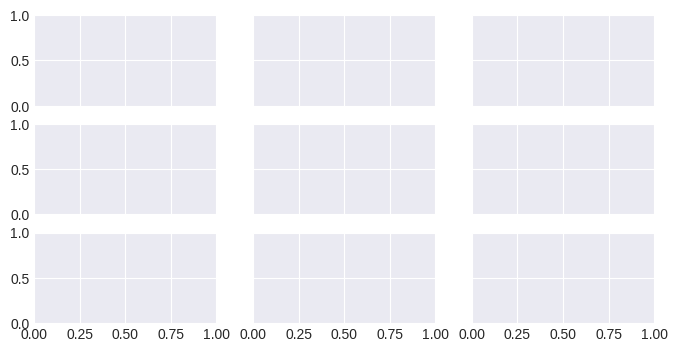

In [24]:
name_map = {
    "npy": "CFA",
    "ahd": "AHD",
    "png": "Baseline"
}
noises      = ["gaussian", "speckle", "saltpepper"]
intensities = ["10", "30", "70"]

bins=[i * 0.0003 for i in range(41)]
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,4))

for n, (noise, intensity) in enumerate(list(product(noises, intensities))):
    for format in formats:
        loss = read_loss_file(loss_path / f"{format}{noise}{intensity}-val-loss.txt")
        ax.flat[n].hist(loss, alpha=.6, bins=bins)
        #ax.flat[n].axis("off")
        ax.flat[n].set_ylim((0,14.9))
        if n < 3:
            ax.flat[n].set_title(f"{intensity}% added noise")
    ax.flat[3].legend([name_map[f] for f in formats], loc="upper right")
fig.supxlabel("MSRE")
syl = fig.supylabel("count")
syl.set_x(syl.get_position()[0] + 0.02)

fig.text(0.08, 0.77, "Gaussian",        va='center', rotation='vertical', fontsize=12)
fig.text(0.08, 0.50, "Speckle",         va='center', rotation='vertical', fontsize=12)
fig.text(0.08, 0.22, "Salt-and-Pepper", va='center', rotation='vertical', fontsize=12)
#fig.text(0.96, 0.5, "hell", color="white")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/gustav/Downloads/ds_proc/loss-shuffle/npygaussian10-val-loss.txt'

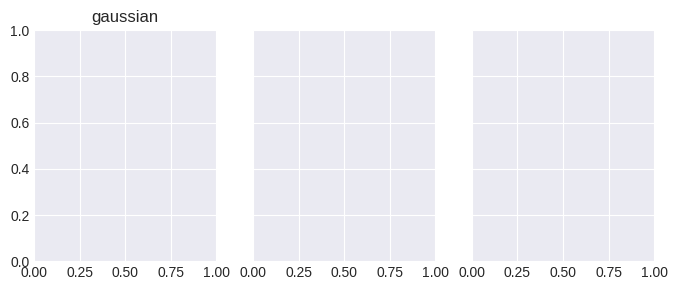

In [23]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, layout=None)#, gridspec_kw={'height_ratios': [8, 1]})
fig.set_size_inches(8, 3)

for n, noise in enumerate(noises):
    ax.flat[n].set_title(noise)
    for format in formats:
        intensities = [str(i*10) for i in range(1,10)]
        losses = np.array([
            read_loss_file(loss_path / f"{format}{noise}{intensity}-val-loss.txt")
            for intensity in intensities
        ])
        mus, stds = np.array([norm.fit(loss) for loss in losses]).T
        #ax.flat[n].set_ylim((0,0.02))
        ax.flat[n].plot(intensities, mus)
        ax.flat[n].fill_between(intensities, mus-stds, mus+stds, alpha=.1)


sigs = [[1,0,1,1,0,0,1,0,1],
        [1,1,1,1,0,0,0,1,0],
        [0,0,1,1,1,1,1,1,1]]

for n, sig in enumerate(sigs):
    for xm in [xm for xm, s in enumerate(sig) if s == 1]:
        #ax.flat[n].annotate('*', xy=(xm, 0), xytext=(xm, -0.0019), # position of text
        #        horizontalalignment='center', verticalalignment='top')
        ax.flat[n].plot([xm], [0], "kx")
    
syl = fig.supylabel("MSRE")
sxl = fig.supxlabel("Noise intensity (%)")
sxl.set_y(sxl.get_position()[1] - 0.05)
syl.set_x(syl.get_position()[0] + 0.027)

#ax.flat[2].xaxis.set_label_coords(0.5, -0.13)

ax.flat[1].legend(list(np.array([[name_map[f], f"{name_map[f]} +/- 1 std"] for f in formats]).flat))
plt.show()

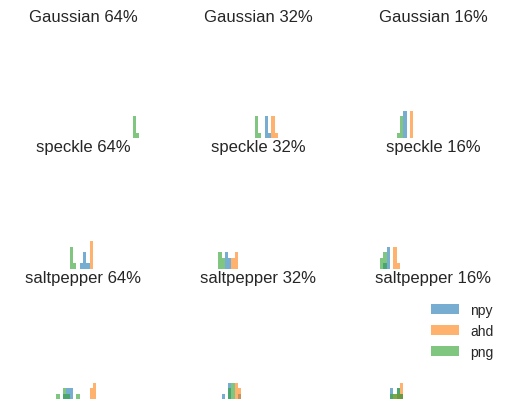

In [37]:
bins=[i * 0.0003 for i in range(41)]
fig, ax = plt.subplots(3,3)

for n, (noise, intensity) in enumerate(list(product(noises, intensities[:3]))):
    for format in formats:
        loss = read_loss_files(loss_path, format, noise, intensity).mean(axis=1)
        ax.flat[n].hist(loss, alpha=.6, bins=bins)
        ax.flat[n].axis("off")
        ax.flat[n].set_ylim((0,20))
        ax.flat[n].set_title(f"{noise} {intensity}%")
    plt.legend(formats)
plt.show()

In [32]:
bins = np.array([i * 0.0006 for i in range(41)])
fig, ax = plt.subplots(3,3, sharex=True, sharey=True)

for n, (noise, intensity) in enumerate(list(product(noises, intensities))):
    for format in formats:
        loss = read_loss_file(loss_path / f"{format}{noise}{intensity}-{}-val-loss.txt")
        mu, std = norm.fit(loss)
        p = norm.pdf(bins, mu, std)
        #ax.flat[n].hist(loss, bins=bins, alpha=.6)
        ax.flat[n].plot(p)
        ax.flat[n].set_ylim((0,700))
        ax.flat[n].set_title(f"{noise} {intensity}%")
    plt.legend(formats)
plt.show()

SyntaxError: f-string: valid expression required before '}' (1767753544.py, line 6)

In [17]:
from torch.utils.data import RandomSampler, Dataset

a = np.random.rand(100)
b = 3 + a

class PairedDataset(Dataset):
    def __init__(self, data_clean, data_noisy):
        self.data_clean = data_clean
        self.data_noisy = data_noisy

    def __len__(self):
        # Assuming both datasets have the same length
        return len(self.data_clean)

    def __getitem__(self, idx):
        clean_image = self.data_clean[idx]
        noisy_image = self.data_noisy[idx]

        return clean_image, noisy_image


ds = PairedDataset(a,b)
rs = RandomSampler(ds, replacement=True, num_samples=20)
ra = np.array([ds[i][0] for i in rs])
np.array([l.T for l in np.split(ra, 4, axis=0)]).mean(axis=0)

array([0.54483667, 0.18809121, 0.571278  , 0.41412321, 0.43907663])

NameError: name 'lru_cache' is not defined

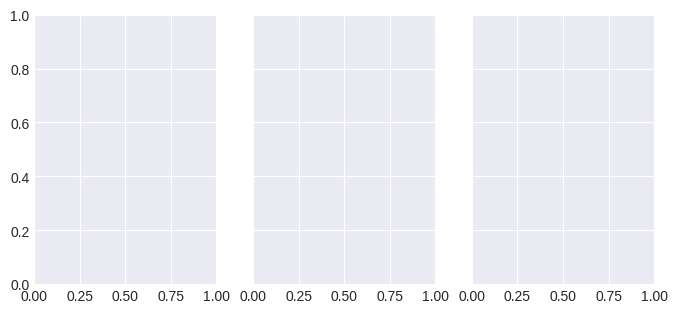

In [17]:
formats     = ["npy", "ahd", "png"]
noises      = ["Gaussian", "speckle", "saltpepper"]
intensities = [
    '64', '32', '16', '8',
    '4', '2', '1', '0.5',
    '0.25', '0.125', '0.0625'
]
loss_path   = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-multi")

fig, ax = plt.subplots(1,3,sharex=True,sharey=True)
fig.set_size_inches(8, 3.5)

@lru_cache(maxsize=128)
def read_loss_file(path):
    with open(path, "r") as f:
        return np.array([float(line.strip()) for line in f.readlines()])

def read_loss_files(path, format, noise, intensity, i=5):
    return np.array([read_loss_file(path / f"{format}{noise.lower()}{intensity}_{n}-val-loss.txt") for n in range(i)])

#fig.set_size_inches(11.5, 4.5)

for n, noise in enumerate(noises):
    ax.flat[n].set_title(noise)
    for color_idx, format in enumerate(formats):
        losses = np.array([
            read_loss_files(loss_path, format, noise, intensity).mean(axis=1)
            for intensity in intensities
        ])
        #print(losses.max(axis=1), losses.mean(axis=1), losses.min(axis=1))
        mean = np.median(losses, axis=1)
        #for loss in losses.T:
        #    ax.flat[n].plot([float(i) for i in intensities], loss, alpha=.2, color=COLORS[color_idx])
        ax.flat[n].plot([float(i) for i in intensities], mean)
        ax.flat[n].fill_between([float(i) for i in intensities], losses.min(axis=1), losses.max(axis=1), alpha=.2)
        #ax.flat[n].fill_between([float(i) for i in intensities], np.quantile(losses,0.3,axis=1), np.quantile(losses, 0.7,axis=1), alpha=.2)

namemap = {
    "npy": "CFA",
    "ahdnogamma": "AHD",
    "ahd": "AHD",
    "png": "Baseline",
    "ahdcc0": "AHD 0 fcc"
}

#plt.yscale('log')
#fig.suptitle("Reconstruction error across format, noise type and noise intensity")
plt.xscale('log')
#plt.ylim([0, 0.007])
syl = fig.supylabel("MSRE")
fig.supxlabel("Noise intensity (%)")
syl.set_x(syl.get_position()[0] + 0.027)
plt.legend(list(np.array([[f"{namemap[format]} median", f"{namemap[format]} max/min"] for format in formats]).flat))

def pctFormat(x, pos):
    return f"{x:.2g}%"

sigs = [[[64,1],[32,1],[16,1],[8,1],[4,1],[2,1],[1,1],[0.5,1],[0.25,1],[0.125,1],[0.0625,1]],
        [[64,1],[32,1],[16,1],[8,1],[4,1],[2,1],[1,1],[0.5,1],[0.25,1],[0.125,1],[0.0625,1]],
        [[64,1],[32,1],[16,0],[8,0],[4,0],[2,1],[1,1],[0.5,1],[0.25,1],[0.125,1],[0.0625,1]]]


for n, sig in enumerate(sigs):
    for xm in [float(xm) for xm, s in sig if s == 1]:
        ax.flat[n].plot([xm], [0], 'kx')

plt.subplots_adjust(top=0.85)

# Plot MSRE before denoising
# No noise, how much does demosaicing destroy
# Why can't we get the performce
# fix dcraw
# Do bilinear
# smooth L1, MAE
# Train for multiple noise levels
fig.gca().xaxis.set_major_formatter(FuncFormatter(pctFormat))
plt.show()

NameError: name 'lines' is not defined

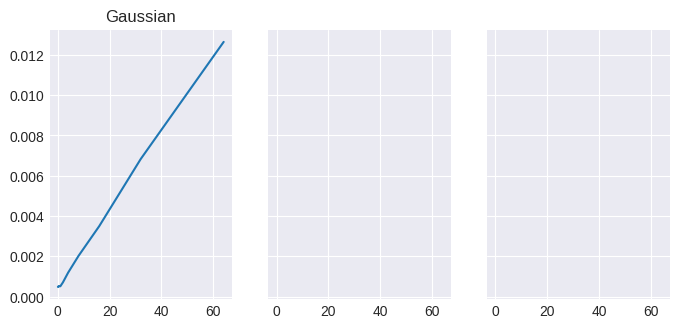

In [18]:
formats     = ["npy","ahd", "ahdnogamma", "ahdcc0"]
noises      = ["Gaussian", "speckle", "saltpepper"]
intensities = [
    '64', '32', '16', '8',
    '4', '2', '1', '0.5',
    '0.25', '0.125', '0.0625'
]
loss_path   = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-multi")

fig, ax = plt.subplots(1,3,sharex=True,sharey=True)
fig.set_size_inches(8, 3.5)

#@lru_cache(maxsize=128)
def read_loss_file(path):
    with open(path, "r") as f:
        return np.array([float(line.strip()) for line in f.readlines()])

def read_loss_files(path, format, noise, intensity, i=5):
    return np.array([read_loss_file(path / f"{format}{noise.lower()}{intensity}_{n}-val-loss.txt") for n in range(i)])

#fig.set_size_inches(11.5, 4.5)

namemap = {
    "npy": "CFA",
    "ahdnogamma": "AHD \n+ linear gamma \n+ median filter",
    "ahd": "AHD \n+ median filter",
    "png": "Baseline",
    "ahdcc0": "AHD \n+ linear gamma"
}

for n, noise in enumerate(noises):
    ax.flat[n].set_title(noise)
    for color_idx, format in enumerate(formats):
        losses = np.array([
            read_loss_files(loss_path, format, noise, intensity).mean(axis=1)
            for intensity in intensities
        ])
        #print(losses.max(axis=1), losses.mean(axis=1), losses.min(axis=1))
        mean = np.median(losses, axis=1)
        #for loss in losses.T:
        #    ax.flat[n].plot([float(i) for i in intensities], loss, alpha=.2, color=COLORS[color_idx])
        line = ax.flat[n].plot([float(i) for i in intensities], mean, label=namemap[format])
        lines.append(line)
        ax.flat[n].fill_between([float(i) for i in intensities], losses.min(axis=1), losses.max(axis=1), alpha=.2)
        #ax.flat[n].fill_between([float(i) for i in intensities], np.quantile(losses,0.3,axis=1), np.quantile(losses, 0.7,axis=1), alpha=.2)


#plt.yscale('log')
#fig.suptitle("Reconstruction error for AHD, noise type and noise intensity")
plt.xscale('log')
plt.ylim([0.0, 0.004])
syl = fig.supylabel("MSRE")
syl.set_x(syl.get_position()[0] + 0.024)
fig.supxlabel("Noise intensity (%)")
plt.legend(bbox_to_anchor=(1, 1.05),labelspacing=1)

def pctFormat(x, pos):
    return f"{x:.2g}%"

plt.subplots_adjust(top=0.85)

# Plot MSRE before denoising
# No noise, how much does demosaicing destroy
# Why can't we get the performce
# fix dcraw
# Do bilinear
# smooth L1, MAE
# Train for multiple noise levels
fig.gca().xaxis.set_major_formatter(FuncFormatter(pctFormat))
plt.show()

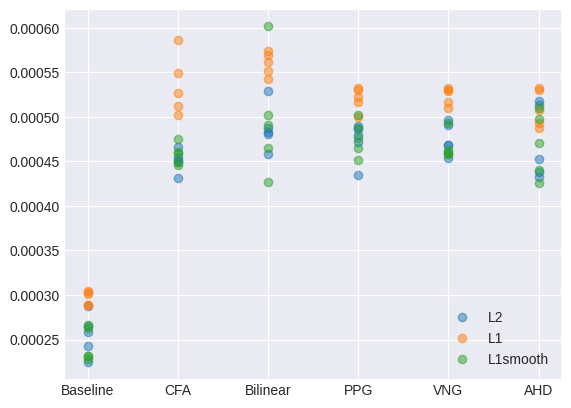

In [88]:
import random

def read_loss_noise0(path, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"noise0_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

noise0_path = Path("/home/gustav/Downloads/ds_proc/loss-noise0")


for loss in ["_L2", "_L1", "_L1smooth"]:
    plt.plot(
    *np.array([np.array(((np.random.rand(5)*.0) + i, read_loss_noise0(noise0_path, format, loss=loss).mean(axis=1))).T                   
     for i, format in enumerate(["pn", "np", "d0", "d1", "d2", "d3"])]).reshape(30,2).T, "o", alpha=0.5)
plt.legend(["L2", "L1", "L1smooth"], loc="lower right")
plt.xticks(range(6), ["Baseline", "CFA", "Bilinear", "PPG", "VNG", "AHD"])
plt.show()


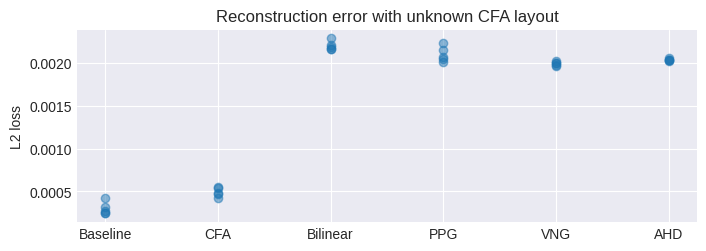

In [579]:
noise0_path = Path("/home/gustav/Downloads/ds_proc/loss-noise0")

plt.figure(figsize=(8, 2.5))
plt.plot(
*np.array([np.array(((np.random.rand(5)*.0) + i, read_loss_noise0(noise0_path, format).mean(axis=1))).T                   
 for i, format in enumerate(["pn", "np", "d0", "d1", "d2", "d3"])]).reshape(30,2).T, "o", alpha=0.5)

plt.title("Reconstruction error with unknown CFA layout")
plt.xticks(range(6), ["Baseline", "CFA", "Bilinear", "PPG", "VNG", "AHD"])
plt.ylabel('L2 loss')
plt.show()

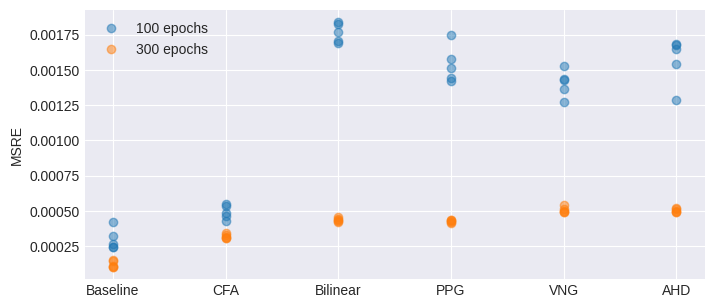

In [90]:
noise0_path = Path("/home/gustav/Downloads/ds_proc/loss-cfa-shuffle")
noise0_path_300 = Path("/home/gustav/Downloads/ds_proc/loss-cfa-shuffle-300")

plt.figure(figsize=(8, 3.5))
plt.plot(
*np.array([np.array(((np.random.rand(5)*.0) + i, read_loss_noise0(noise0_path, format).mean(axis=1))).T                   
 for i, format in enumerate(["pn", "np", "d0", "d1", "d2", "d3"])]).reshape(30,2).T, "o", alpha=0.5)
plt.plot(
*np.array([np.array(((np.random.rand(5)*.0) + i, read_loss_noise0(noise0_path_300, format).mean(axis=1))).T                   
 for i, format in enumerate(["pn", "np", "d0", "d1", "d2", "d3"])]).reshape(30,2).T, "o", alpha=0.5)
plt.legend(["100 epochs", "300 epochs"])
#plt.title("Reconstruction error with unknown CFA layout")
plt.xticks(range(6), ["Baseline", "CFA", "Bilinear", "PPG", "VNG", "AHD"])
plt.ylabel('MSRE')
#plt.yscale("log")
plt.show()

In [37]:
[np.array(((np.random.rand(5)*.0) + i, read_loss_noise0(noise0_path_300, format).mean(axis=1))).T                   
 for i, format in enumerate(["pn", "np", "d0", "d1", "d2", "d3"])]

[array([[0.        , 0.000102  ],
        [0.        , 0.0001028 ],
        [0.        , 0.00015005],
        [0.        , 0.00010874],
        [0.        , 0.00014037]]),
 array([[1.00000000e+00, 3.12880550e-04],
        [1.00000000e+00, 3.27912181e-04],
        [1.00000000e+00, 3.04333026e-04],
        [1.00000000e+00, 3.07006825e-04],
        [1.00000000e+00, 3.43623587e-04]]),
 array([[2.00000000e+00, 4.22192527e-04],
        [2.00000000e+00, 4.41531185e-04],
        [2.00000000e+00, 4.30480785e-04],
        [2.00000000e+00, 4.36625657e-04],
        [2.00000000e+00, 4.57149624e-04]]),
 array([[3.00000000e+00, 4.33320305e-04],
        [3.00000000e+00, 4.18913477e-04],
        [3.00000000e+00, 4.16090868e-04],
        [3.00000000e+00, 4.24500145e-04],
        [3.00000000e+00, 4.37066596e-04]]),
 array([[4.00000000e+00, 4.93812577e-04],
        [4.00000000e+00, 5.09482647e-04],
        [4.00000000e+00, 4.96415331e-04],
        [4.00000000e+00, 4.91508713e-04],
        [4.00000000e+00,

In [38]:
[((np.zeros(5) + i + 2, read_loss_noise0(n_path, f"{format}{i}").mean(axis=1))) for i in range(4)]

NameError: name 'n_path' is not defined

In [93]:
from scipy.stats import mannwhitneyu
for ds in ["imagenette2-160", "EuroSat", "CelebA"]:
    print()
    print(ds)
    perf = [(format, read_loss_final(n_path, ds, format).mean(axis=1)) for i, format in enumerate(["npy", "d0", "d1", "d2", "d3"])]
    for (f1, a), (f2, b) in list(combinations(perf, 2))[:4]:
        print(f1, f2, mannwhitneyu(a, b))


imagenette2-160
npy d0 MannwhitneyuResult(statistic=7.0, pvalue=0.30952380952380953)
npy d1 MannwhitneyuResult(statistic=6.0, pvalue=0.2222222222222222)
npy d2 MannwhitneyuResult(statistic=2.0, pvalue=0.031746031746031744)
npy d3 MannwhitneyuResult(statistic=0.0, pvalue=0.007936507936507936)

EuroSat
npy d0 MannwhitneyuResult(statistic=9.0, pvalue=0.5476190476190477)
npy d1 MannwhitneyuResult(statistic=5.0, pvalue=0.15079365079365079)
npy d2 MannwhitneyuResult(statistic=9.0, pvalue=0.5476190476190477)
npy d3 MannwhitneyuResult(statistic=7.0, pvalue=0.30952380952380953)

CelebA
npy d0 MannwhitneyuResult(statistic=2.0, pvalue=0.031746031746031744)
npy d1 MannwhitneyuResult(statistic=12.0, pvalue=1.0)
npy d2 MannwhitneyuResult(statistic=15.0, pvalue=0.6904761904761905)
npy d3 MannwhitneyuResult(statistic=16.0, pvalue=0.5476190476190477)


4
(4, 4)
(4, 4)
(4, 4)
npy: (5,)
(4, 4) 5
npy: (5,)
(4, 4) 5
npy: (5,)
(4, 4) 5


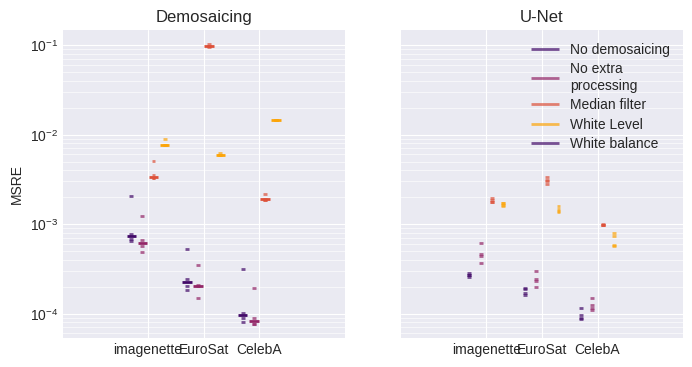

In [144]:
n_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-final")
d_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/dists")
from matplotlib.pyplot import figure
import matplotlib.cm as cm

fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))


# Move color
#ax[0].plot([])

#for n, (sf, mark) in enumerate(zip(["d", "m", "w", "a"],["P", "X", "D", "v"])):
#    us = [np.array([read_det_loss(d_path, ds, sf, i).mean() for i in range(4)])
#          for ds in ["imagenette2-160", "EuroSat", "Celeba"]]
#    print(us)
#    ax[0].plot(us, mark)

colors = [cm.inferno(i) for i in range(0, 256, 256 // 5)]
print(len(colors[1:5]))

for offset, ds in enumerate(["imagenette2-160", "EuroSat", "Celeba"]):
    us = np.array([[read_det_loss(d_path, ds, sf, i).mean() for i in range(4)]
                    for n, sf in enumerate(["d", "m", "w", "a"])])
    print(us.shape)
    pos = np.arange(4)*.2 + offset + .7
    ax[0].eventplot(us, orientation="vertical", 
                        lineoffsets=pos, linewidth=2, linelength=.07,
                        colors=colors[1:5], alpha=.7)
    ax[0].eventplot(np.expand_dims(np.median(us, axis=1), 1), 
                    orientation="vertical", 
                    lineoffsets=pos, linewidth=2, linelength=.17,
                    colors=colors[1:5])

# Model perf
for offset, ds in enumerate(["imagenette2-160", "EuroSat", "CelebA"]):
    npy = np.array(read_loss_final(n_path, ds, "npy", 5).mean(1))
    print("npy:", npy.shape)
    us  = np.array([[read_loss_final(n_path, ds, f"{sf}{i}", 5).mean() for i in range(4)]
                    for n, sf in enumerate(["d", "m", "w", "a"])])
    print(us.shape, len(colors[:5]))
    pos = np.arange(4)*.2 + offset + .7
    ax[1].eventplot(us, orientation="vertical", 
                        lineoffsets=pos, linewidth=2, linelength=.07,
                        colors=colors[1:5], alpha=.7)
    
#ax[1].plot(
#    *np.array([np.array(((np.random.rand(5)*.0) + (x*.07) + i, read_loss_final(n_path, ds, f"npy").mean(axis=1))).T
#    for i, ds in enumerate(["imagenette2-160", "EuroSat", "CelebA"])]).reshape(15,2).T, "s", alpha=0.5)

#for x, (format, mark) in enumerate(zip(["d", "m", "w", "a"],["P", "X", "D", "v"])):
#    ax[1].plot(
#        *np.array([np.array((np.zeros(5) + (x*.07) -0.075 + i, read_loss_final(n_path, ds, f"{format}3").mean(axis=1))).T
#        for i, ds in enumerate(["imagenette2-160", "EuroSat", "CelebA"])]).reshape(15,2).T, mark, alpha=0.5)

ax[1].set_xticks(range(1,4), ["imagenette", "EuroSat", "CelebA"])
plt.legend([
    "No demosaicing",
    "No extra \nprocessing",
    "Median filter",
    "White Level",
    "White balance"
],
    labelspacing=0.4,
    markerscale=1.2)
ax[0].set_ylabel('MSRE')
ax[1].set_yscale("log")
ax[0].set_title("Demosaicing")
ax[1].set_title("U-Net")
ax[0].grid(which='minor', alpha=.6)
ax[1].grid(which='minor', alpha=.6)
plt.show()#format="svg"

[array([0.00208661]), array([0.00053073]), array([0.00031832])]
[array([0.00123099]), array([0.00034646]), array([0.00019434])]
[array([0.00506656]), array([0.10270202]), array([0.00217357])]
[array([0.00901072]), array([0.0061972]), array([0.01464055])]


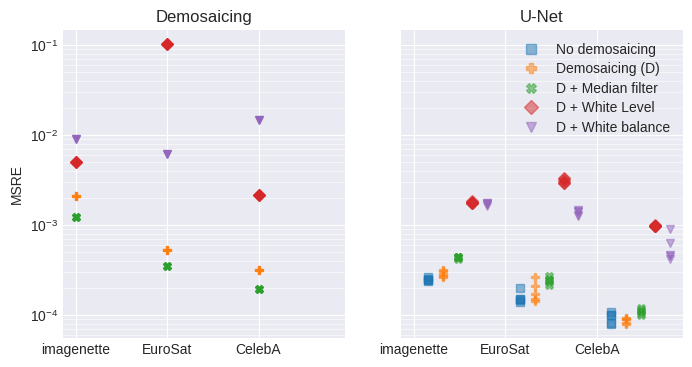

In [171]:
n_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-final")
d_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/dists")
from matplotlib.pyplot import figure

fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))


# Move color
ax[0].plot([])

for n, (sf, mark) in enumerate(zip(["d", "m", "w", "a"],["P", "X", "D", "v"])):
    us = [np.array([read_det_loss(d_path, ds, sf, i).mean() for i in range(1)])
          for ds in ["imagenette2-160", "EuroSat", "Celeba"]]
    print(us)
    ax[0].plot(us, mark)

# Model perf
ax[1].plot(
    *np.array([np.array((np.ones(5)*x*0 + i + .16, read_loss_final(n_path, ds, f"npy").mean(axis=1))).T
    for i, ds in enumerate(["imagenette2-160", "EuroSat", "CelebA"])]).reshape(15,2).T, "s", alpha=0.5)
for x, (format, mark) in enumerate(zip(["d", "m", "w", "a"],["P", "X", "D", "v"])):
    ax[1].plot(
        *np.array([np.array((np.ones(5)*x*.16 + i + .32, read_loss_final(n_path, ds, f"{format}3").mean(axis=1))).T
        for i, ds in enumerate(["imagenette2-160", "EuroSat", "CelebA"])]).reshape(15,2).T, mark, alpha=0.5)

ax[1].set_xticks(range(0,3), ["imagenette", "EuroSat", "CelebA"])
plt.legend([
    "No demosaicing",
    "Demosaicing (D)",
    "D + Median filter",
    "D + White Level",
    "D + White balance"
],
    labelspacing=0.4,
    markerscale=1.2)
ax[0].set_ylabel('MSRE')
ax[1].set_yscale("log")
ax[0].set_title("Demosaicing")
ax[1].set_title("U-Net")
ax[0].grid(which='minor', alpha=.6)
ax[1].grid(which='minor', alpha=.6)
plt.show()#format="svg"

(3, 5) [[2.51401698e-04 2.44186534e-04 2.44823164e-04 2.40407350e-04
  2.62290626e-04]
 [1.39485129e-04 1.49732706e-04 1.98719132e-04 1.44268072e-04
  1.50812934e-04]
 [8.04914033e-05 7.87107497e-05 1.00642555e-04 1.07449753e-04
  9.98020503e-05]]


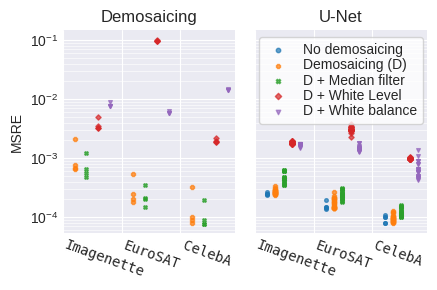

In [19]:
n_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-final")
d_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/dists")
from matplotlib.pyplot import figure

fig, ax = plt.subplots(1,2, figsize=(4.5,3), sharex=True, sharey=True, layout="tight")

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

ax[0].scatter([],[])

us = np.array([
    read_loss_final(n_path, ds, "npy").mean(1)
    for ds in ["imagenette2-160", "EuroSat", "CelebA"]
])
print(us.shape, us)
x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(5)) + .21
ax[1].scatter(x_pos.flat, us.flat, alpha=.7, s=7)

for n, (sf, mark) in enumerate(zip(["d", "m", "w", "a"],["P", "X", "D", "v"])):
    us  = np.array([
        [read_det_loss(d_path, ds, sf, q).mean()
         for q in range(4)]
        for ds in ["imagenette2-160", "EuroSat", "Celeba"]
    ])
    x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(4)) + (n+1)*.2
    ax[0].scatter(x_pos.flat, us.flat, marker=mark, alpha=.7, s=7)
    
    us = np.array([
        np.array([read_loss_final(n_path, ds, f"{sf}{q}").mean(1) for q in range(4)]).flatten()
        for ds in ["imagenette2-160", "EuroSat", "CelebA"]
    ])
    x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(20)) + (n+2)*.14 +0.07
    ax[1].scatter(x_pos.flat, us.flat, marker=mark, alpha=.7, s=7)
    
    
ax[0].set_xticks(range(0,3), ["Imagenette", "EuroSAT", "CelebA"], fontname="monospace")
ax[1].set_xticks(range(0,3), ["Imagenette", "EuroSAT", "CelebA"], fontname="monospace")

plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=-20, ha="left" )
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=-20, ha="left" )

plt.legend([
    "No demosaicing",
    "Demosaicing (D)",
    "D + Median filter",
    "D + White Level",
    "D + White balance"
],
    labelspacing=0.1,
    markerscale=1.2,
    frameon=True,
    facecolor="white",
    loc='upper center')
ax[0].set_ylabel('MSRE')
ax[1].set_yscale("log")
ax[0].set_title("Demosaicing")
ax[1].set_title("U-Net")
ax[0].grid(which='minor', alpha=.6)
ax[1].grid(which='minor', alpha=.6)
plt.show()#format="svg"

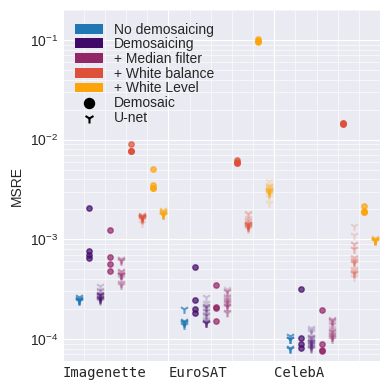

In [20]:
n_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-final")
d_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/dists")
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True, layout="tight")

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

colors = [cm.inferno(i) for i in range(0, 256, 256 // 5)]

us = np.array([
    read_loss_final(n_path, ds, "npy").mean(1)
    for ds in ["imagenette2-160", "EuroSat", "CelebA"]
])
x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(5)) + .15
ax.scatter(x_pos.flat, us.flat, marker="1", alpha=.7, s=40)

for n, (sf, mark, color) in enumerate(zip(["d", "m", "a", "w"],["P", "X", "D", "v"], colors[1:])):
    us  = np.array([
        [read_det_loss(d_path, ds, sf, q).mean()
         for q in range(4)]
        for ds in ["imagenette2-160", "EuroSat", "Celeba"]
    ])
    x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(4)) + (n+1)*.2 + .05
    ax.scatter(x_pos.flat, us.flat, alpha=.7, s=15, color=color)
    
    us = np.array([
        np.array([read_loss_final(n_path, ds, f"{sf}{q}").mean(1) for q in range(4)]).flatten()
        for ds in ["imagenette2-160", "EuroSat", "CelebA"]
    ])
    x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(20)) + (n+1)*.2 + .15
    ax.scatter(x_pos.flat, us.flat, marker="1", alpha=.2, s=40, color=color)
    
    
ax.set_xticks(range(0,3), ["Imagenette", "EuroSAT", "CelebA"], fontname="monospace")
ax.set_xticks(np.arange(0,3,1/5), minor=True)
plt.setp( ax.xaxis.get_majorticklabels(), ha="left" )

custom_lines = [*[
    Patch(facecolor=color, label=label)
    for color, label in zip([None, *colors[1:]], [
    "No demosaicing",
    "Demosaicing",
    "+ Median filter",    
    "+ White balance",
    "+ White Level"
])],*[
    ax.scatter([0],[0],marker=marker, color="black", label=label)
    for [marker, label] in [["o", "Demosaic"], ["1", "U-net"]]
]]

plt.legend(
    handles=custom_lines,
    labelspacing=0.05,
    markerscale=1.2,
    #frameon=True,
    facecolor="white",
    loc='upper left')
ax.set_ylabel('MSRE')
ax.set_yscale("log", base=10)
ax.set_xlim(0,3)
ax.set_ylim(0.00006,0.2)
ax.grid(which='minor', alpha=.6)
#plt.title("MSRE reduction after denoising")
plt.show()#format="svg"

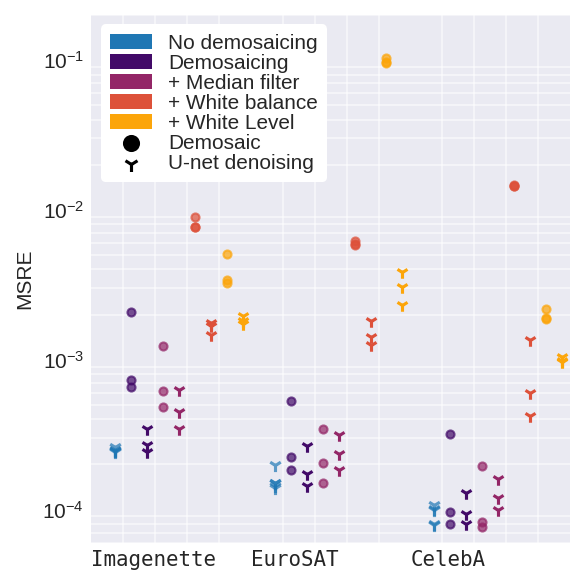

In [10]:
n_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-final")
d_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/dists")
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.style.use("seaborn-v0_8-dark")
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True, layout="tight")

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

def three_point_summary(array):
    arr = np.array(array)
    return [np.min(arr), np.median(arr), np.max(arr)]

colors = [cm.inferno(i) for i in range(0, 256, 256 // 5)]

us = np.array([
    read_loss_final(n_path, ds, "npy").mean(1)
    for ds in ["imagenette2-160", "EuroSat", "CelebA"]
])
x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(5)) + .15
ax.scatter(x_pos.flat, us.flat, marker="1", alpha=.7, s=40)

for n, (sf, mark, color) in enumerate(zip(["d", "m", "a", "w"],["P", "X", "D", "v"], colors[1:])):
    us  = np.array([
        three_point_summary([read_det_loss(d_path, ds, sf, q).mean() for q in range(4)])
        for ds in ["imagenette2-160", "EuroSat", "Celeba"]
    ])
    x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(3)) + (n+1)*.2 + .05
    ax.scatter(x_pos.flat, us.flat, alpha=.7, s=15, color=color)
    
    us = np.array([
        three_point_summary(
            np.array([read_loss_final(n_path, ds, f"{sf}{q}").mean(1) for q in range(4)]).flatten()
        )
        for ds in ["imagenette2-160", "EuroSat", "CelebA"]
    ])
    x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(3)) + (n+1)*.2 + .15
    ax.scatter(x_pos.flat, us.flat, marker="1", color=color)
    
    
ax.set_xticks(range(0,3), ["Imagenette", "EuroSAT", "CelebA"], fontname="monospace")
ax.set_xticks(np.arange(0,3,1/5), minor=True)
plt.setp( ax.xaxis.get_majorticklabels(), ha="left" )

custom_lines = [*[
    Patch(facecolor=color, label=label)
    for color, label in zip([None, *colors[1:]], [
    "No demosaicing",
    "Demosaicing",
    "+ Median filter",    
    "+ White balance",
    "+ White Level"
])],*[
    ax.scatter([0],[0],marker=marker, color="black", label=label)
    for [marker, label] in [["o", "Demosaic"], ["1", "U-net denoising"]]
]]

plt.legend(
    handles=custom_lines,
    labelspacing=0.05,
    markerscale=1.2,
    frameon=True,
    facecolor="white",
    edgecolor="white",
    framealpha=1,
    loc='upper left')
ax.set_ylabel('MSRE')
ax.set_yscale("log", base=10)
ax.set_xlim(0,3)
ax.set_ylim(0.00006,0.2)
ax.grid(which='minor', alpha=.6)
mpl.rcParams['figure.dpi'] = 150
#plt.title("Min/Median/Max MSRE after denoising by processing")
plt.show()#format="svg"

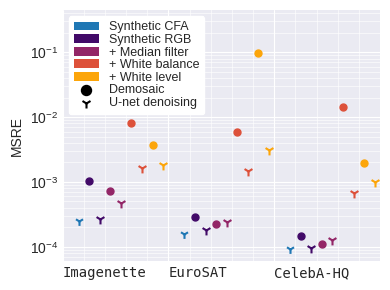

In [9]:
n_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-final")
d_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/dists")
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl


fig, ax = plt.subplots(1,1, figsize=(4,3), layout="tight")

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

def three_point_summary(array):
    arr = np.array(array)
    return [np.min(arr), np.median(arr), np.max(arr)]

colors = [cm.inferno(i) for i in range(0, 256, 256 // 5)]

us = np.array([
    read_loss_final(n_path, ds, "npy").mean()
    for ds in ["imagenette2-160", "EuroSat", "CelebA"]
])
x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(1)) + .15
ax.scatter(x_pos.flat, us.flat, marker="1", s=40)

for n, (sf, mark, color) in enumerate(zip(["d", "m", "a", "w"],["P", "X", "D", "v"], colors[1:])):
    us  = np.array([
        np.array([read_det_loss(d_path, ds, sf, q).mean() for q in range(4)]).mean()
        for ds in ["imagenette2-160", "EuroSat", "Celeba"]
    ])
    x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(1)) + (n+1)*.2 + .05
    ax.scatter(x_pos.flat, us.flat, s=25, color=color)
    
    us = np.array([
        np.array([read_loss_final(n_path, ds, f"{sf}{q}").mean(1) for q in range(4)]).mean()
        for ds in ["imagenette2-160", "EuroSat", "CelebA"]
    ])
    x_pos = np.add.outer(np.linspace(0,2,3), np.zeros(1)) + (n+1)*.2 + .15
    ax.scatter(x_pos.flat, us.flat, marker="1", color=color, s=50)
    
    
ax.set_xticks(range(0,3), ["Imagenette", "EuroSAT", "CelebA-HQ"], font="monospace")
ax.set_xticks(np.arange(0,3,1/5), minor=True)
plt.setp( ax.xaxis.get_majorticklabels(), ha="left" )

custom_lines = [*[
    Patch(facecolor=color, label=label)
    for color, label in zip([None, *colors[1:]], [
    "Synthetic CFA",
    "Synthetic RGB",
    "+ Median filter",    
    "+ White balance",
    "+ White level"
])],*[
    ax.scatter([0],[0],marker=marker, color="black", label=label)
    for [marker, label] in [["o", "Demosaic"], ["1", "U-net denoising"]]
]]

plt.legend(
    handles=custom_lines,
    labelspacing=0.05,
    markerscale=1.2,
    frameon=True,
    facecolor="white",
    edgecolor="white",
    framealpha=1,
    fontsize=9,
    loc='upper left')
ax.set_ylabel('MSRE')
ax.set_yscale("log", base=10)
ax.set_xlim(0,3)
ax.set_ylim(0.00006,0.45)
ax.grid(which='minor', alpha=.6)
mpl.rcParams['figure.dpi'] = 150
plt.savefig('isp-msre.pdf', bbox_inches='tight', pad_inches=0)
#plt.title("Min/Median/Max MSRE after denoising by processing")
plt.show()#format="svg"

4



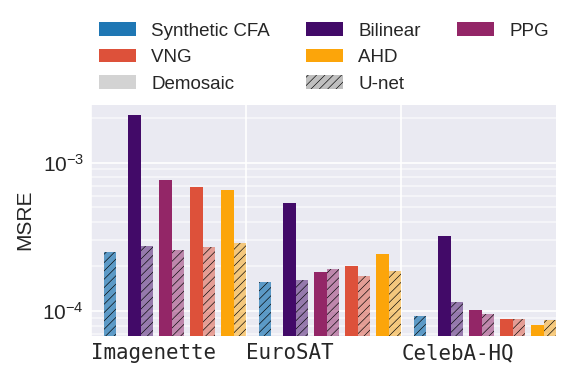

In [10]:
import matplotlib as mpl

fig, ax = plt.subplots(1,1, figsize=(4,2))

colors = [cm.inferno(i) for i in range(0, 256, 256 // 5)]
print(len(colors[1:5]))

data_cfa = np.array([1.6e-4,9.3e-5,1.6e-4])
data_cfa = np.array([
    read_loss_final(n_path, ds, "npy").mean()
    for ds in ["imagenette2-160", "EuroSat", "CelebA"]
])
pos = np.arange(0,3,1) + 0.12
ax.bar(pos, data_cfa, width=0.08, alpha=.7, hatch="//////")

data_dm = np.array([
#  Bilinear PPG,    VNG,    AHD
    3.2e-4, 1.0e-4, 8.9e-5, 8.0e-5, # Demosaic
    3.2e-4, 1.0e-4, 8.9e-5, 8.0e-5,
    5.3e-4, 1.8e-4, 2.0e-4, 2.4e-4,
]).reshape(3,4)
data_dm = np.array([
    [read_det_loss(d_path, ds, "d", q).mean() for q in range(4)]
    for ds in ["imagenette2-160", "EuroSat", "Celeba"]
])
print()
pos = np.add.outer(np.arange(0,3,1), np.arange(0,.8,0.2)+.28)
ax.bar(pos.flat, data_dm.flat, width=0.08, color=colors[1:5])

data_un = np.array([
    1.6e-4, 1.9e-4, 1.7e-4, 1.9e-4,
    1.2e-4, 9.5e-5, 8.9e-5, 8.7e-5,
    1.6e-4, 1.9e-4, 1.7e-4, 1.9e-4
]).reshape(3,4)
data_un = np.array([
        [read_loss_final(n_path, ds, f"d{q}").mean() for q in range(4)]
        for ds in ["imagenette2-160", "EuroSat", "CelebA"]
])

pos = np.add.outer(np.arange(0,3,1), np.arange(0,.8,0.2)+.36)
ax.bar(pos.flat, data_un.flat, width=0.08, color=colors[1:5], alpha=.5, linewidth=20, hatch="//////")

plt.rcParams['hatch.linewidth'] = .3

custom_lines = [*[
    Patch(facecolor=color, label=label)
    for color, label in zip([None, colors[1], colors[2], colors[3], colors[4], "white", "lightgrey", "gray"], [
        "Synthetic CFA",
        "Bilinear",
        "PPG",
        "VNG  ",
        "AHD  ",
        "",
        "Demosaic"
])],
    Patch(facecolor="grey", label="U-net", hatch="//////", alpha=.5),
    Patch(facecolor="white", label="")
]

t_lines = list(np.array(custom_lines).reshape(3,3).T.flat)

ax.legend(handles=t_lines, bbox_to_anchor=(0, 1.02, 1, 0.2), 
          fontsize=9, loc="lower left",
          mode="expand", borderaxespad=0, ncol=3)

ax.set_xticks(range(0,3), ["Imagenette", "EuroSAT", "CelebA-HQ"], font="monospace")
plt.setp( ax.xaxis.get_majorticklabels(), ha="left" )
ax.set_xlim(0,3)
#ax.set_ylim(7.0e-5, 7.0e-4)
ax.grid(which='minor', alpha=.6)
ax.set_ylabel('MSRE')
ax.set_yscale("log")
plt.grid(which='major', alpha=1)
#ax.set_ylim(8e-5,3e-4)
#ax.set_title("MSRE after denoising by demosaicing algorithm")
#ax.yaxis.set_label_coords(-0.07,.5)
mpl.rcParams['figure.dpi'] = 150
plt.savefig('demosaic-msre.pdf', bbox_inches='tight', pad_inches=0)
plt.show() # 4e-4 = 4*10^-4

In [29]:
from scipy.stats import mannwhitneyu

data_cfa = np.array([
    read_loss_final(n_path, ds, "npy").mean(1)
    for ds in ["imagenette2-160", "EuroSat", "CelebA"]
])

data_dm = np.array([
    [read_det_loss(d_path, ds, "d", q).mean() for q in range(4)]
    for ds in ["imagenette2-160", "EuroSat", "Celeba"]
])

data_un = np.array([
        [read_loss_final(n_path, ds, f"d{q}").mean() for q in range(4)]
        for ds in ["imagenette2-160", "EuroSat", "CelebA"]
])

for cfa_us, dm_us, un_us in zip(data_cfa, data_dm, data_un):
    print(mannwhitneyu(cfa_us, dm_us))
    print(mannwhitneyu(cfa_us, un_us))

MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(0.3333333333333333))
MannwhitneyuResult(statistic=np.float64(1.0), pvalue=np.float64(0.031746031746031744))
MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(0.3333333333333333))
MannwhitneyuResult(statistic=np.float64(4.0), pvalue=np.float64(0.19047619047619047))
MannwhitneyuResult(statistic=np.float64(4.0), pvalue=np.float64(0.6666666666666666))
MannwhitneyuResult(statistic=np.float64(9.0), pvalue=np.float64(0.9047619047619049))


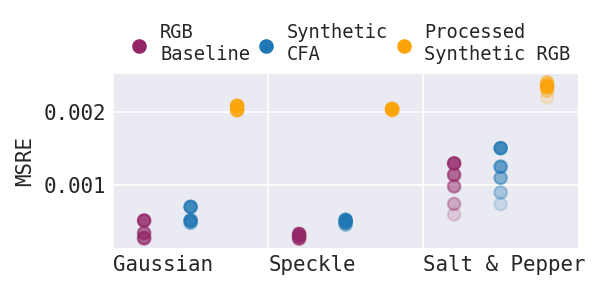

In [15]:
import matplotlib.cm as cm
import math

colors = [cm.inferno(i) for i in range(0, 256, 256 // 5)]
colors      = [colors[2], "tab:blue", colors[4]]
formats     = ["png", "npy", "ahdcc0"]
noises      = ["Gaussian", "speckle", "saltpepper"]
intensities = [
    '64', '32', '16', '8',
    '4', '2', '1', '0.5',
    '0.25', '0.125', '0.0625'
][5:]
loss_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-multi")

fig, ax = plt.subplots(1,1,sharex=True,sharey=True)
fig.set_size_inches(4, 1.5)

def read_loss_file(path):
    with open(path, "r") as f:
        return np.array([float(line.strip()) for line in f.readlines()])

def read_loss_files(path, format, noise, intensity, i=5):
    return np.array([read_loss_file(path / f"{format}{noise.lower()}{intensity}_{n}-val-loss.txt") for n in range(i)])

for n, noise in enumerate(noises):
    for color_idx, format in enumerate(formats):
        losses = np.array([
            read_loss_files(loss_path, format, noise, intensity).mean(axis=1)
            for intensity in intensities
        ])
        mean = np.median(losses, axis=1)
        ax.scatter([n+(color_idx*.3)+.2 for i in intensities], mean, color=colors[color_idx], alpha=[(math.log2(float(i))+4)/6 for i in intensities])

ax.set_xticks(range(0,3), ["Gaussian", "Speckle", "Salt & Pepper"], font="monospace")
plt.setp( ax.xaxis.get_majorticklabels(), ha="left" )
legend = [
    ax.scatter([],[], label=label, color=color)
    for color, label in zip(colors, ["RGB\nBaseline", "Synthetic\nCFA", "Processed\nSynthetic RGB"])]
plt.legend(handles=legend,
           bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
           fontsize=9,
           mode="expand", borderaxespad=0, ncol=3, handletextpad=0.1)
plt.ylabel('MSRE')
plt.grid(which='major', alpha=1)
#plt.title("MSRE for 0.06% to 2% noise")
plt.xlim(0,3)

plt.savefig('noise-msre.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

(3, 3, 6)


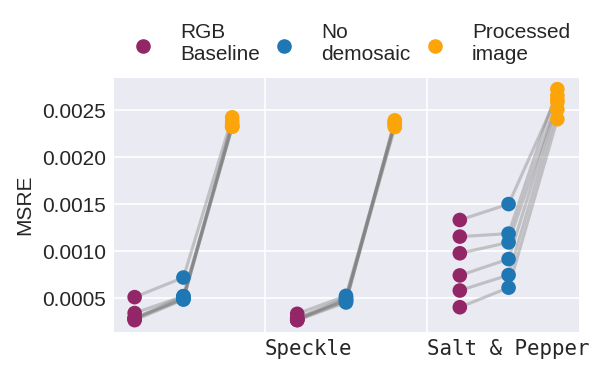

In [81]:
import matplotlib.cm as cm

colors = [cm.inferno(i) for i in range(0, 256, 256 // 5)]
colors      = [colors[2], "tab:blue", colors[4]]
formats     = ["png", "npy", "ahd"]
noises      = ["Gaussian", "speckle", "saltpepper"]
intensities = [
    '64', '32', '16', '8',
    '4', '2', '1', '0.5',
    '0.25', '0.125', '0.0625'
][5:]
flt_i = [float(i) for i in intensities]
loss_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/loss-multi")

fig, ax = plt.subplots(1,1,sharex=True,sharey=True)
fig.set_size_inches(4, 2.2)

def read_loss_file(path):
    with open(path, "r") as f:
        return np.array([float(line.strip()) for line in f.readlines()])

def read_loss_files(path, format, noise, intensity, i=5):
    return np.array([read_loss_file(path / f"{format}{noise.lower()}{intensity}_{n}-val-loss.txt") for n in range(i)])

losses = np.array([
    [np.array([
        read_loss_files(loss_path, format, noise, intensity).mean(axis=1)
        for intensity in intensities
    ]).mean(1)
    for format in formats]
    for noise in noises
])
pos = np.add.outer(np.add.outer(np.arange(0,3,1), np.arange(0,.9,0.3)) +.2, np.zeros(6))

for i in range(3):
    for j in range(6):
        ax.plot   (pos[i,:,j], losses[i,:,j], color="grey", alpha=.4, zorder=1)
        ax.scatter(pos[i,:,j], losses[i,:,j], color=colors, zorder=2)

print(losses.shape)
ax.set_xticks(range(0,3), ["Gaussian", "Speckle", "Salt & Pepper"], fontname="monospace")
plt.setp( ax.xaxis.get_majorticklabels(), ha="left" )
legend = [
    ax.scatter([],[], label=label, color=color)
    for color, label in zip(colors, ["RGB\nBaseline", "No\ndemosaic", "Processed\nimage"])]
plt.legend(handles=legend,
           bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
           mode="expand", borderaxespad=0, ncol=3)
plt.ylabel('MSRE')
#plt.title("MSRE for 0.06% to 2% noise")
plt.show()

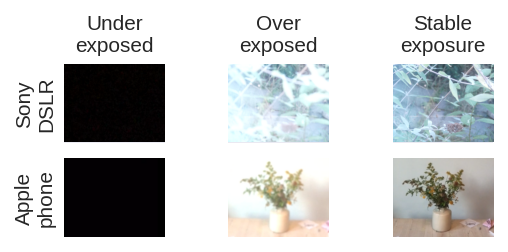

In [38]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(4, 1.5)

plt.grid(False)

for i in range(1,7):
    im = Image.open(Path("/home/gustav/Pictures/Screenshots/") / f"exposure-series-{i}.png")
    ax.flat[i-1].imshow(im)
    ax.flat[i-1].set_xticks([])
    ax.flat[i-1].set_yticks([])

for a, title in zip(ax[0], ["Under\nexposed", "Over\nexposed", "Stable\nexposure"]):
    a.set_title(title, fontsize=10)

for a, title in zip(ax.T[0], ["Sony\nDSLR", "Apple\nphone"]):
    a.set_ylabel(title)

In [26]:
n_path = Path("/home/gustav/Downloads/ds_proc/loss-final")
from matplotlib.pyplot import figure
figure(num=None, figsize=(7, 4))

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

plt.plot(
*np.array([np.array(((np.random.rand(5)*.0) + i, read_loss_final(n_path, "imagenette2-160", format).mean(axis=1))).T                   
 for i, format in enumerate(["png", "npy", "d0", "d1", "d2", "d3"])]).reshape(30,2).T, "o", alpha=0.5)


for x, format in enumerate(["w", "m", "mw","a", "aw", "amw"]):
    plt.plot(
        *np.array([np.array(((np.random.rand(5)*.0) + (x*.05) + i + 1.8, read_loss_final(n_path, "imagenette2-160", f"{format}{i}").mean(axis=1))).T                   
        for i, j in enumerate(["d0", "d1", "d2", "d3"])]).reshape(20,2).T, "o", alpha=0.5)

#plt.plot(
#*np.array([np.array(((np.random.rand(5)*.0) + i + 1, read_loss_final(n_path, "rand_scale_imagenette2-160", format).mean(axis=1))).T                   
# for i, format in enumerate(["npy"])]).reshape(5,2).T, "o", alpha=0.5)

#plt.title("MSRE across processing steps - imagenette - 300 epochs")
plt.xticks(range(6), ["Original signal", "CFA", "Bilinear", "PPG", "VNG", "AHD"])
plt.ylabel('MSRE')
plt.legend([
    "No extra \nprocessing",
    "White Level",
    "Median filter",
    "Median filter \n+ White Level",
    "White balance",
    "White balance \n+ White level",
    "Median filter \n+ White balance \n+ white level"
],  bbox_to_anchor=(1, 1.05), 
    labelspacing=1,
    markerscale=1.2)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/gustav/Downloads/ds_proc/loss-final/imagenette2-160_png_0-val-loss.txt'

<Figure size 700x400 with 0 Axes>

d 0 1.2E-04
d 1 9.5E-05
d 2 8.9E-05
d 3 8.7E-05
npy 9.3E-05


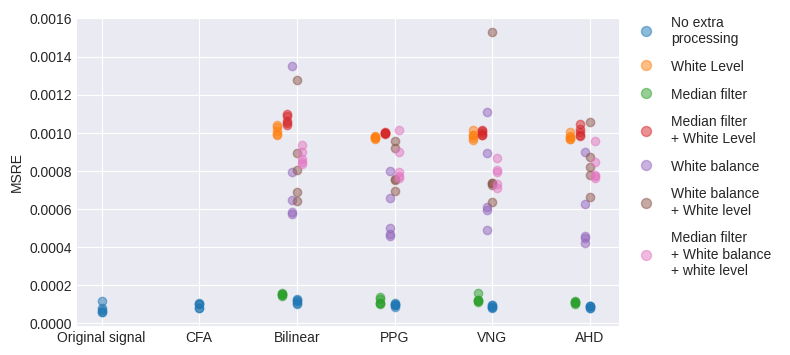

In [453]:
n_path = Path("/home/gustav/Downloads/ds_proc/loss-final")
from matplotlib.pyplot import figure
figure(num=None, figsize=(7, 4))

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

plt.plot(
*np.array([np.array(((np.random.rand(5)*.0) + i, read_loss_final(n_path, "CelebA", format).mean(axis=1))).T                   
 for i, format in enumerate(["png", "npy", "d0", "d1", "d2", "d3"])]).reshape(30,2).T, "o", alpha=0.5)

for x, format in enumerate(["w", "m", "mw","a", "aw", "amw"]):
    plt.plot(
        *np.array([np.array(((np.random.rand(5)*.0) + (x*.05) + i + 1.8, read_loss_final(n_path, "CelebA", f"{format}{i}").mean(axis=1))).T                   
        for i, j in enumerate(["d0", "d1", "d2", "d3"])]).reshape(20,2).T, "o", alpha=0.5)

#plt.plot(
#*np.array([np.array(((np.random.rand(5)*.0) + i + 1, read_loss_final(n_path, "rand_scale_CelebA", format).mean(axis=1))).T                   
# for i, format in enumerate(["npy"])]).reshape(5,2).T, "o", alpha=0.5)
for f in ["d"]:
    for i in range(4):
        print(f, i, "%.1E" % read_loss_final(n_path, "CelebA", f"{f}{i}").mean())
print("npy", "%.1E" %  read_loss_final(n_path, "CelebA", f"npy").mean())

#plt.title("MSRE across processing steps - CelebA - 100 epochs")
plt.xticks(range(6), ["Original signal", "CFA", "Bilinear", "PPG", "VNG", "AHD"])
plt.ylabel('MSRE')
plt.legend([
    "No extra \nprocessing",
    "White Level",
    "Median filter",
    "Median filter \n+ White Level",
    "White balance",
    "White balance \n+ White level",
    "Median filter \n+ White balance \n+ white level"
],  bbox_to_anchor=(1, 1.05), 
    labelspacing=1,
    markerscale=1.2)
plt.show()

npy 1.6E-04
d 0 1.6E-04
d 1 1.9E-04
d 2 1.7E-04
d 3 1.9E-04


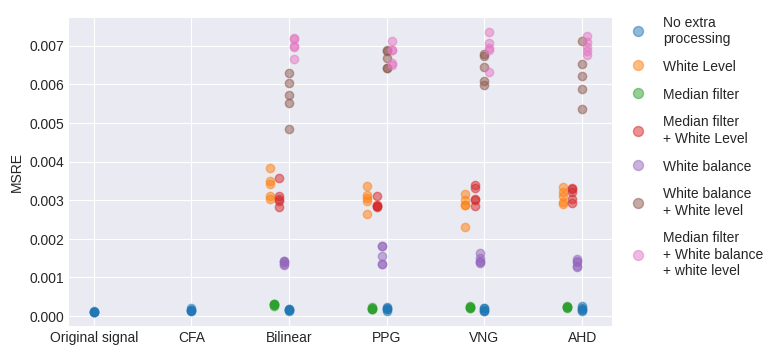

In [475]:
n_path = Path("/home/gustav/Downloads/ds_proc/loss-final")
from matplotlib.pyplot import figure
figure(num=None, figsize=(7, 4))

def read_loss_final(path, ds, format, i=5, loss=""):
    return np.array([read_loss_file(path / f"{ds}_{format}{loss}_{n}-val-loss.txt") for n in range(i)])

plt.plot(
*np.array([np.array(((np.random.rand(5)*.0) + i, read_loss_final(n_path, "EuroSat", format).mean(axis=1))).T                   
 for i, format in enumerate(["png", "npy", "d0", "d1", "d2", "d3"])]).reshape(30,2).T, "o", alpha=0.5)

for x, format in enumerate(["w", "m", "mw","a", "aw", "amw"]):
    plt.plot(
        *np.array([np.array(((np.random.rand(5)*.0) + (x*.05) + i + 1.8, read_loss_final(n_path, "EuroSat", f"{format}{i}").mean(axis=1))).T                   
        for i, j in enumerate(["d0", "d1", "d2", "d3"])]).reshape(20,2).T, "o", alpha=0.5)


print("npy", "%.1E" %  read_loss_final(n_path, "EuroSat", f"npy").mean())
for f in ["d"]:
    for i in range(4):
        print(f, i, "%.1E" % read_loss_final(n_path, "EuroSat", f"{f}{i}").mean())


#plt.plot(
#*np.array([np.array(((np.random.rand(5)*.0) + i + 1, read_loss_final(n_path, "rand_scale_EuroSat", format).mean(axis=1))).T                   
# for i, format in enumerate(["npy"])]).reshape(5,2).T, "o", alpha=0.5)

#plt.title("MSRE across processing steps - EuroSat - 100 epochs")
plt.xticks(range(6), ["Original signal", "CFA", "Bilinear", "PPG", "VNG", "AHD"])
plt.ylabel('MSRE')
plt.legend([
    "No extra \nprocessing",
    "White Level",
    "Median filter",
    "Median filter \n+ White Level",
    "White balance",
    "White balance \n+ White level",
    "Median filter \n+ White balance \n+ white level"
],  bbox_to_anchor=(1, 1.05), 
    labelspacing=1,
    markerscale=1.2)
plt.show()

In [477]:
[64*2**(-i) for i in range(12)]

[64, 32.0, 16.0, 8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125]

In [473]:
from scipy.stats import mannwhitneyu
for ds in ["imagenette2-160", "CelebA", "EuroSat"]:
    print()
    print(ds)

    loss = [(f, read_loss_final(n_path, ds, f).mean(1)) for f in ["npy","d0", "d1", "d2", "d3"]]
    for (x, a), (y,b) in combinations(loss, 2):
        print(x, y, "%.2E" % mannwhitneyu(a,b).pvalue, "%.2E" % b.mean())


imagenette2-160
npy d0 3.10E-01 2.72E-04
npy d1 2.22E-01 2.58E-04
npy d2 3.17E-02 2.71E-04
npy d3 7.94E-03 2.87E-04
d0 d1 1.00E+00 2.58E-04
d0 d2 4.21E-01 2.71E-04
d0 d3 3.10E-01 2.87E-04
d1 d2 2.22E-01 2.71E-04
d1 d3 3.17E-02 2.87E-04
d2 d3 3.10E-01 2.87E-04

CelebA
npy d0 3.17E-02 1.15E-04
npy d1 1.00E+00 9.53E-05
npy d2 6.90E-01 8.86E-05
npy d3 5.48E-01 8.65E-05
d0 d1 3.17E-02 9.53E-05
d0 d2 7.94E-03 8.86E-05
d0 d3 7.94E-03 8.65E-05
d1 d2 3.10E-01 8.86E-05
d1 d3 5.56E-02 8.65E-05
d2 d3 6.90E-01 8.65E-05

EuroSat
npy d0 5.48E-01 1.63E-04
npy d1 1.51E-01 1.93E-04
npy d2 5.48E-01 1.71E-04
npy d3 3.10E-01 1.88E-04
d0 d1 1.51E-01 1.93E-04
d0 d2 1.00E+00 1.71E-04
d0 d3 6.90E-01 1.88E-04
d1 d2 3.10E-01 1.71E-04
d1 d3 6.90E-01 1.88E-04
d2 d3 5.48E-01 1.88E-04


In [446]:
"%.2E" % 0.00016300559774520736

'1.63E-04'

3.2E-04
1.0E-04
8.9E-05
8.0E-05
1.9E-04
7.7E-05
8.9E-05
7.6E-05
2.2E-03
1.9E-03
1.9E-03
1.9E-03
1.5E-02
1.5E-02
1.5E-02
1.5E-02


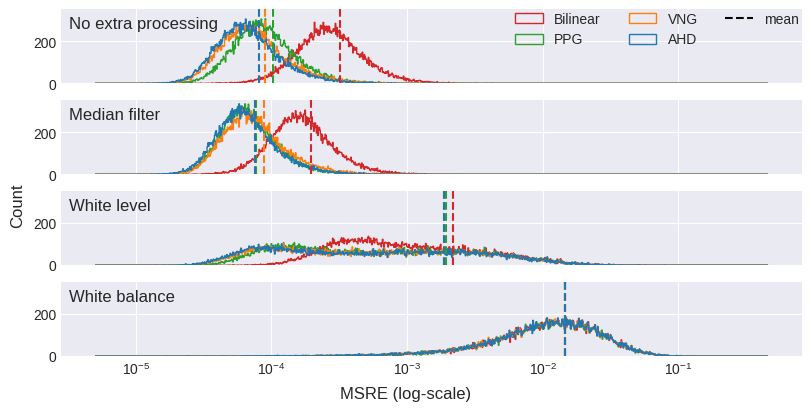

In [456]:
def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

fig, ax = plt.subplots(4,1,sharex=True, sharey=True, layout='constrained')
fig.set_size_inches(8, 4)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

loss_path = Path("/home/gustav/Downloads/ds_proc/det-loss")
#bins = [i*0.000045 - 0.000028 for i in range(1,1000)]
bins = [i*0.00046 - 0.000455 for i in range(1,1000)]
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

for n, sf in enumerate(["d", "m", "w","a"]):
    xs = [read_det_loss(loss_path, "Celeba", sf, 3-i) for i in range(4)]
    us = [x.mean() for x in xs]
    [print("%.1E" % u) for u in reversed(us)]
    ax.flat[n].hist(xs, logbins, histtype='step')
    ax.flat[n].axvline(x=0.001, color="black", linestyle="--", ymin=0, ymax=0)
    for u, c in reversed(list(zip(us, default_colors))):
        ax.flat[n].axvline(x=u, color=c, linestyle='--', label=f'x={xm}')

ax.flat[0].set_title("No extra processing", loc='left', y=1, x=0.01, pad=-14)
ax.flat[1].set_title("Median filter",       loc='left', y=1, x=0.01, pad=-14) 
ax.flat[2].set_title("White level",         loc='left', y=1, x=0.01, pad=-14)
ax.flat[3].set_title("White balance",       loc='left', y=1, x=0.01, pad=-14)

fig.legend(["Bilinear", "PPG", "VNG", "AHD", "mean"], ncol=3)
plt.xscale("log")
#fig.suptitle('Histograms of L2 distance between baseline signal and demosaiced signal - CelebA')
fig.supxlabel('MSRE (log-scale)')
fig.supylabel('Count')
plt.show()


In [ ]:
us_celeba = [
    [8.039926142998107e-05, 8.910942029115177e-05, 0.00010244717560966212, 0.00031831775259415733],
    [0.0018706715330255369, 0.0018782161468276172, 0.001924134696488727, 0.0021735693617301877],
    [7.615036787198429e-05, 8.863984018998963e-05, 7.731645540570753e-05, 0.00019434455288671113],
    [0.014511789177005812, 0.014536167118193407, 0.014514557741625867, 0.014640546977364284]
]

us_eurosat = [
    [0.00024351701184899933, 0.0002022542481323331, 0.00018257164926555763, 0.0005307331507023331],
    [0.0973573266592198, 0.09554532782728657, 0.09791333961242486, 0.10270201533864437],
    [0.00020318635387233102, 0.0002072020937992723, 0.00015012105903057697, 0.0003464637352589711],
    [0.005927629640155053, 0.005895094618053783, 0.005862984579446978, 0.006197204960756574]
]

us_imagenette = [
    [0.0006550037954109348, 0.0006887008706518806, 0.00076719822357204, 0.002086613053671817],
    [0.003272063189597735, 0.0032674916652940815, 0.003495848332015982, 0.00506655944659176],
    [0.0005673123448897454, 0.0006623195442981758, 0.00048629666410023915, 0.0012309910616993902],
    [0.007672673915492315, 0.007748698825564151, 0.007729933205671312, 0.009010718589705183]
]


5.3E-04
1.8E-04
2.0E-04
2.4E-04
3.5E-04
1.5E-04
2.1E-04
2.0E-04
1.0E-01
9.8E-02
9.6E-02
9.7E-02
6.2E-03
5.9E-03
5.9E-03
5.9E-03


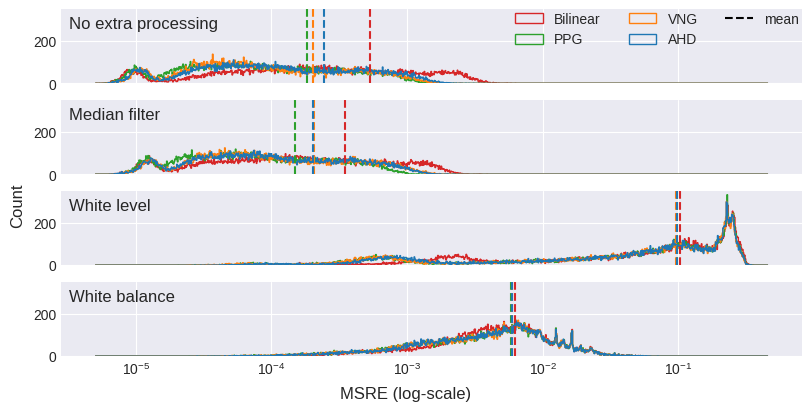

In [457]:
def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

fig, ax = plt.subplots(4,1,sharex=True, sharey=True, layout='constrained')
fig.set_size_inches(8, 4)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

loss_path = Path("/home/gustav/Downloads/ds_proc/dists")
bins = [i*0.00046 - 0.000455 for i in range(1,1000)]
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

for n, sf in enumerate(["d", "m", "w","a"]):
    xs = [read_det_loss(loss_path, "EuroSat", sf, 3-i) for i in range(4)]
    us = [x.mean() for x in xs]
    [print("%.1E" % u) for u in reversed(us)]
    ax.flat[n].hist(xs, logbins, histtype='step')
    ax.flat[n].axvline(x=0.001, color="black", linestyle="--", ymin=0, ymax=0)
    for u, c in reversed(list(zip(us, default_colors))):
        ax.flat[n].axvline(x=u, color=c, linestyle='--', label=f'x={xm}')

ax.flat[0].set_title("No extra processing", loc='left', y=1, x=0.01, pad=-14)
ax.flat[1].set_title("Median filter",       loc='left', y=1, x=0.01, pad=-14) 
ax.flat[2].set_title("White level",         loc='left', y=1, x=0.01, pad=-14)
ax.flat[3].set_title("White balance",       loc='left', y=1, x=0.01, pad=-14)

fig.legend(["Bilinear", "PPG", "VNG", "AHD", "mean"], ncol=3)
plt.xscale("log")
#fig.suptitle('Histograms of L2 distance between baseline signal and demosaiced signal - EuroSat')
fig.supxlabel('MSRE (log-scale)')
fig.supylabel('Count')
plt.show()


[0.0006550037954109348, 0.0006887008706518806, 0.00076719822357204, 0.002086613053671817]
[0.0005673123448897454, 0.0006623195442981758, 0.00048629666410023915, 0.0012309910616993902]
[0.003272063189597735, 0.0032674916652940815, 0.003495848332015982, 0.00506655944659176]
[0.007672673915492315, 0.007748698825564151, 0.007729933205671312, 0.009010718589705183]


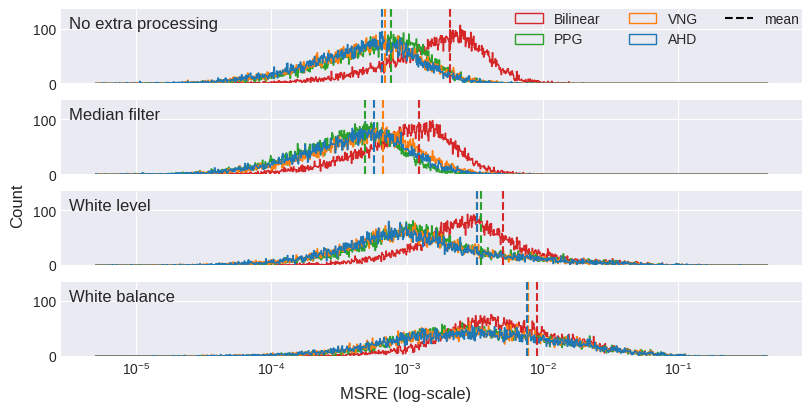

In [274]:
def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

fig, ax = plt.subplots(4,1,sharex=True, sharey=True, layout='constrained')
fig.set_size_inches(8, 4)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

loss_path = Path("/home/gustav/Downloads/ds_proc/dists")
#bins = [i*0.00013 - 0.0001 for i in range(1,1000)]
bins = [i*0.00046 - 0.000455 for i in range(1,1000)]
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

for n, sf in enumerate(["d", "m", "w","a"]):
    xs = [read_det_loss(loss_path, "imagenette2-160", sf, 3-i) for i in range(4)]
    us = [x.mean() for x in xs]
    print(us)
    ax.flat[n].hist(xs, logbins, histtype='step')
    ax.flat[n].set_ylim([0, 135])
    ax.flat[n].axvline(x=0.001, color="black", linestyle="--", ymin=0, ymax=0)
    for u, c in reversed(list(zip(us, default_colors))):
        ax.flat[n].axvline(x=u, color=c, linestyle='--')

ax.flat[0].set_title("No extra processing", loc='left', y=1, x=0.01, pad=-14)
ax.flat[1].set_title("Median filter",       loc='left', y=1, x=0.01, pad=-14) 
ax.flat[2].set_title("White level",         loc='left', y=1, x=0.01, pad=-14)
ax.flat[3].set_title("White balance",       loc='left', y=1, x=0.01, pad=-14)

fig.legend(["Bilinear", "PPG", "VNG", "AHD", "mean"], ncol=3)#, bbox_to_anchor=(1.13,.635))
plt.xscale("log")
#fig.suptitle('Histograms of L2 distance between baseline signal and demosaiced signal - Imagenette')
fig.supxlabel('MSRE (log-scale)')
fig.supylabel('Count')
plt.show()


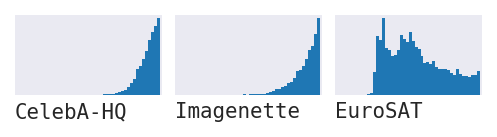

In [27]:
import matplotlib as mpl

def read_det_perc(path, ds, subfolder, i, p):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-{p}.txt"))

fig, ax = plt.subplots(1,3, layout='constrained')
fig.set_size_inches(3.2, .8)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

loss_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/det-loss")
bins = [i*0.02 for i in range(0,50)]

for n, (sf, t) in enumerate(zip(["CelebA", "imagenette2-160", "EuroSat"],["CelebA-HQ", "Imagenette", "EuroSAT"])):
    p1  = [read_det_perc(loss_path, sf, "d", 0, 1)  for i in range(1)]
    p99 = [read_det_perc(loss_path, sf, "d", 0, 99) for i in range(1)]
    #ax.flat[n].hist(p1, bins)
    ax.flat[n].hist(p99, bins, rwidth=1)
    ax.flat[n].set_xticks([0],[t], fontname="monospace")
    ax.flat[n].set_yticks([])
    ax.flat[n].set_xlim(0,1)
    plt.setp( ax.flat[n].xaxis.get_majorticklabels(), ha="left", font="monospace" )
    #ax.flat[n].set_title(t, fontsize='medium', loc='left')
    

#fig.suptitle('White level, 1st and 99th percentile per image')
#fig.legend(["1%", "99%"], bbox_to_anchor=(1.1,.57))
#fig.supxlabel('level')
mpl.rcParams['figure.dpi'] = 150
#fig.supylabel('99th percentile\n    White level', fontsize=10)
#fig.supxlabel('Level', fontsize=10)
plt.savefig('wl.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [69]:
def read_det_perc(path, ds, subfolder, i, p):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-{p}.txt"))

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

loss_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/det-loss")
bins = [i*0.02 for i in range(0,50)]

for n, sf in enumerate(["CelebA", "imagenette2-160", "EuroSat"]):
    p1  = np.array([read_det_perc(loss_path, sf, "d", 0, 1)  for i in range(1)])
    p99 = np.array([read_det_perc(loss_path, sf, "d", 0, 99) for i in range(1)])
    print(sf,(p99).mean())

CelebA 0.9201265218098958
imagenette2-160 0.9225737919322551
EuroSat 0.5911934596874096


[0.002086613053671817, 0.00076719822357204, 0.0006887008706518806, 0.0006550037954109348]
[0.0012309910616993902, 0.00048629666410023915, 0.0006623195442981758, 0.0005673123448897454]
[0.00506655944659176, 0.003495848332015982, 0.0032674916652940815, 0.003272063189597735]
[0.004156258892001638, 0.0031979101208755127, 0.003330056083362225, 0.0032381653542184795]


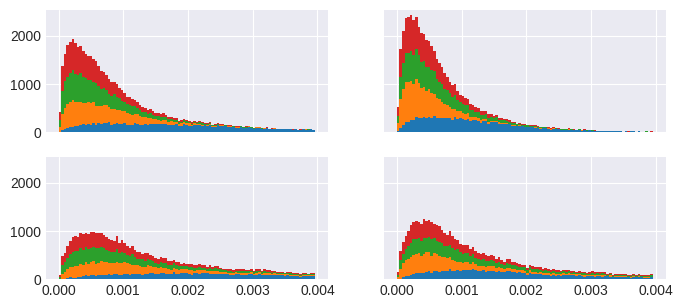

In [365]:
def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

fig, ax = plt.subplots(2,2,sharex=True, sharey=True)
fig.set_size_inches(8, 3.5)

loss_path = Path("/home/gustav/Downloads/ds_proc/det-loss")
bins = [i*0.00004 for i in range(100)]

for n, sf in enumerate(["d", "m", "w", "mw"]):
    xs = [read_det_loss(loss_path, "imagenette2", sf, i) for i in range(4)]
    us = [x.mean() for x in xs]
    print(us)
    ax.flat[n].hist(xs, bins, stacked=True)
plt.show()


In [379]:
clean_image = torch.zeros((3,23,42))
crop = (20,20)
cw, ch = crop
_, w, h = clean_image.shape
clean_image = clean_image[:, ((w-cw)//2):((w-cw)//2)+cw, ((h-ch)//2):((h-ch)//2)+ch]
clean_image.size()

torch.Size([3, 20, 20])

In [ ]:
def read_det_loss(path, ds, subfolder, i):
    return np.array(read_loss_file(path / f"{ds}-{subfolder}{i}-det-loss.txt"))

fig, ax = plt.subplots(2,2,sharex=True, sharey=True)
fig.set_size_inches(8, 3.5)

loss_path = Path("/home/gustav/Downloads/ds_proc/det-loss")
bins = [i*0.00004 for i in range(100)]

for n, sf in enumerate(["d", "m", "w", "mw"]):
    xs = [read_det_loss(loss_path, "CelebA", sf, i) for i in range(4)]
    us = [x.mean() for x in xs]
    print(us)
    ax.flat[n].hist(xs, bins, stacked=True)
plt.show()

In [601]:
res        = np.zeros((100000, 3))
res       += np.random.uniform(.5, 1, (100000,1))
res[:, 0] *= np.random.uniform(1/2.4, 1/1.9, (100000))
res[:, 2] *= np.random.uniform(1/1.9, 1/1.5, (100000))
#np.save("rand100k", res)

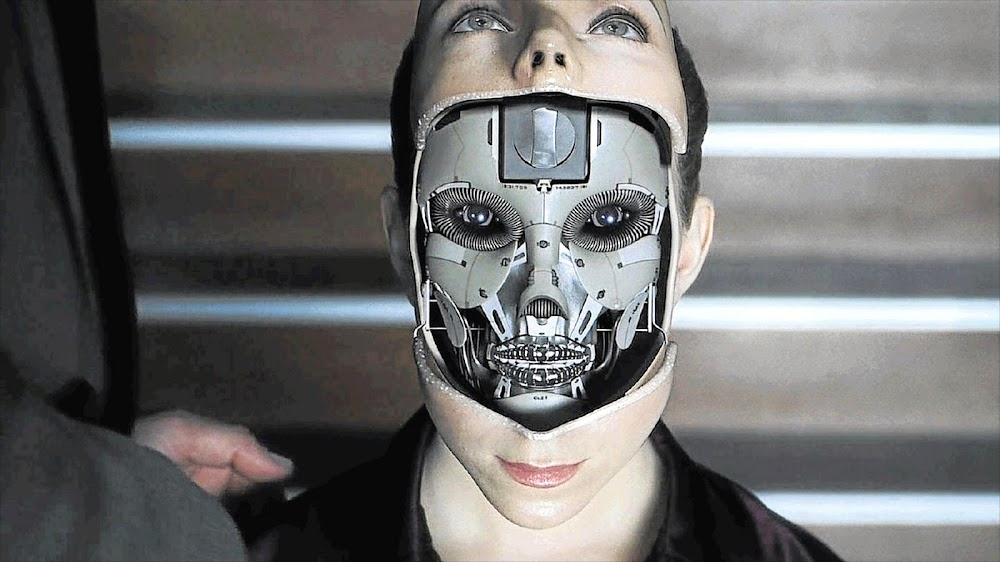

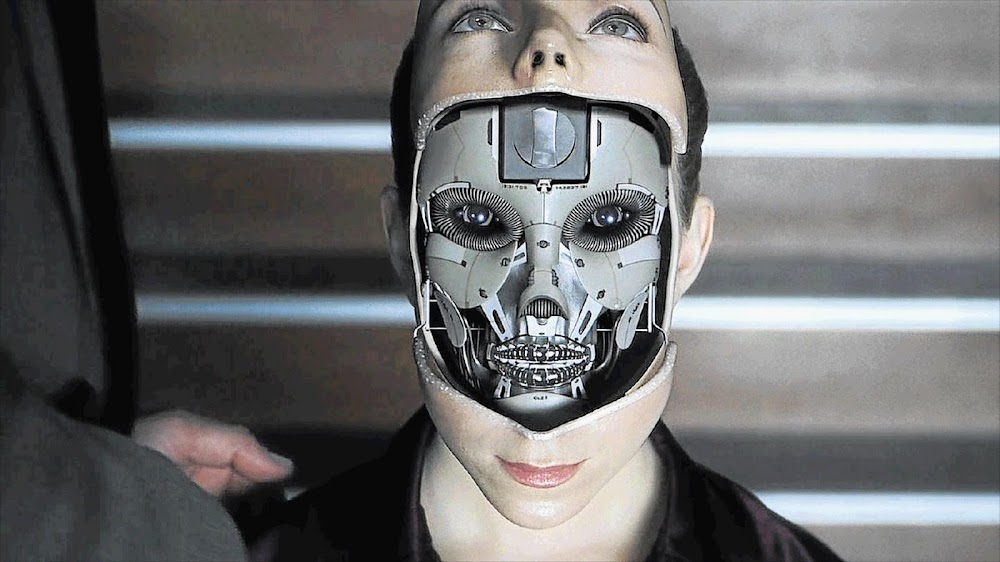

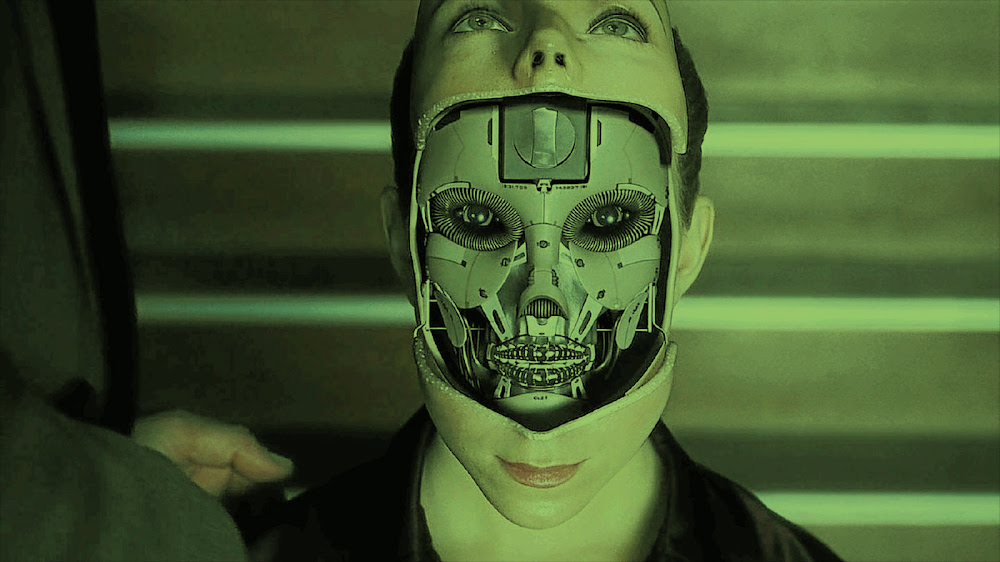

In [216]:
from PIL import Image
img = torch.Tensor(np.array(Image.open("/home/gustav/Pictures/robot.jpg"), dtype=np.uint8).transpose(2,0,1))

img_2 = img.clone()
img *= 0.8
img[0] *= 0.77
img[2] *= 0.53
img_3 = img.clone()

avg = torch.mean(img, (1,2)) / 255
for a, channel in zip(avg, img):
    channel *= 1 / a
whitelevel = (1/(torch.quantile(img, 0.99) / 255))
img *= whitelevel
img = torch.clamp(img, 0, 255)

display(Image.fromarray(np.array(img, dtype=np.uint8).transpose(1,2,0)))
display(Image.fromarray(np.array(img_2, dtype=np.uint8).transpose(1,2,0)))
Image.fromarray(np.array(img_3, dtype=np.uint8).transpose(1,2,0))

In [22]:
a_path = Path("/home/gustav/Downloads/imagenette2-160")
b_path = Path("/home/gustav/Downloads/EuroSAT")
c_path = Path("/home/gustav/Downloads/celeba_hq_256")

res = np.zeros((3,250,250,3), dtype=np.uint8)

for b, p in enumerate([a_path,b_path,c_path]):
    files = np.array(findAllFiles(p))
    n = len(files)
    subset_idx = np.random.choice(np.random.randint(0, n), 25, replace=False)
    r2 = np.zeros((25, 50, 50, 3), dtype=np.uint8)
    for i, f_path in enumerate(files[subset_idx]):
        img = Image.open(f_path).convert("RGB")
        w, h = img.size
        a = min(w,h)
        #print(w,h,a,((w-a)//2, (h-a)//2, a+((w-a)//2),a+((h-a)//2)))
        img = img.crop(((w-a)//2, (h-a)//2, a+((w-a)//2),a+((h-a)//2)))
        img.thumbnail((50,50))
        r2[i] = np.array(img)
    r2 = r2.reshape(5,5,50,50,3)
    for x, xs in enumerate(r2):
        for y, ys in enumerate(xs):
            res[b, x*50:(x+1)*50, y*50:(y+1)*50, :] += ys
            
    display(Image.fromarray(res[b]))

NameError: name 'findAllFiles' is not defined

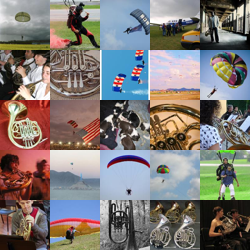

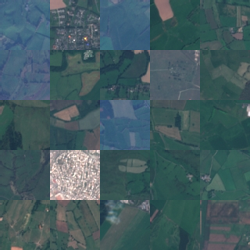

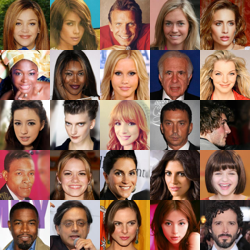

In [292]:
a_path = Path("/home/gustav/Downloads/imagenette2-160")
b_path = Path("/home/gustav/Downloads/EuroSAT")
c_path = Path("/home/gustav/Downloads/celeba_hq_256")

res = np.zeros((3,250,250,3), dtype=np.uint8)

for b, p in enumerate([a_path,b_path,c_path]):
    files = np.array(findAllFiles(p))
    n = len(files)
    subset_idx = np.random.choice(np.random.randint(0, n), 25, replace=False)
    r2 = np.zeros((25, 50, 50, 3), dtype=np.uint8)
    for i, f_path in enumerate(files[subset_idx]):
        img = Image.open(f_path).convert("RGB")
        w, h = img.size
        a = min(w,h)
        #print(w,h,a,((w-a)//2, (h-a)//2, a+((w-a)//2),a+((h-a)//2)))
        img = img.crop(((w-a)//2, (h-a)//2, a+((w-a)//2),a+((h-a)//2)))
        img.thumbnail((50,50))
        r2[i] = np.array(img)
    r2 = r2.reshape(5,5,50,50,3)
    for x, xs in enumerate(r2):
        for y, ys in enumerate(xs):
            res[b, x*50:(x+1)*50, y*50:(y+1)*50, :] += ys
            
    display(Image.fromarray(res[b]))

In [22]:
subset_idx = np.random.choice(np.random.randint(0, n), 36, replace=False)
files = np.concatenate([np.array(findAllFiles(p)) for p in [a_path,b_path,c_path]])

In [31]:
rand        = np.ones((100000, 3))
rand       += np.random.uniform(.5, 1, (100000,1))
rand[:, 0] *= np.random.uniform(1/2.4, 1/1.9, (100000))
rand[:, 2] *= np.random.uniform(1/1.9, 1/1.5, (100000))

In [35]:
rand        = np.ones((100000, 3))
#rand       += np.random.uniform(.5, 1, (100000,1))
rand[:, 0] *= np.random.uniform(.5, 1, (100000))
rand[:, 2] *= np.random.uniform(.5, 1, (100000))

In [29]:
from pathlib import Path
import numpy as np
from PIL import Image
from scipy.ndimage import median_filter

a_path = Path("/home/gustav/old/bachelor/ds_proc/imagenette2-160")
b_path = Path("/home/gustav/old/bachelor/ds_proc/EuroSAT")
c_path = Path("/home/gustav/old/bachelor/ds_proc/celeba_hq_256")

res = np.zeros((2, 300,300,3), dtype=np.uint8)


n = len(files)

r2 = np.zeros((36, 50, 50, 3), dtype=np.uint8)
for i, f_path in enumerate(files[subset_idx]):
    img = Image.open(f_path).convert("RGB")
    w, h = img.size
    a = min(w,h)
    #print(w,h,a,((w-a)//2, (h-a)//2, a+((w-a)//2),a+((h-a)//2)))
    img = img.crop(((w-a)//2, (h-a)//2, a+((w-a)//2),a+((h-a)//2)))
    img.thumbnail((50,50))
    #img *= rand[i+100]
    r2[i] = np.array(img)
r2 = r2.reshape(6,6,50,50,3)
for x, xs in enumerate(r2):
    for y, ys in enumerate(xs):
        ys = ys.astype(np.float64)
        #ys *= np.random.uniform(.1, .99)
        ys = ys.astype(np.uint8)
        res[0, x*50:(x+1)*50, y*50:(y+1)*50, :] += ys
        ys = ys.astype(np.float64)
        #wl = np.percentile(ys, 99) / 255
        #ys *= 1 / wl
        #avg = np.mean(ys, (0,1)) / 255
        #ys = ys * (np.max(avg) / avg)
        ys = median_filter(ys, 3)
        #ys = np.clip(ys, 0, 255)
        ys = ys.astype(np.uint8)
        res[1, x*50:(x+1)*50, y*50:(y+1)*50, :] += ys
        
display(Image.fromarray(res[0]))
display(Image.fromarray(res[1]))

IndexError: index 36 is out of bounds for axis 0 with size 36

In [34]:
a_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/imagenette2-160")
b_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/EuroSAT")
c_path = Path("/home/gustav/opgaver/old/bachelor/ds_proc/celeba_hq_256")

/home/gustav/opgaver/old/bachelor/ds_proc/imagenette2-160


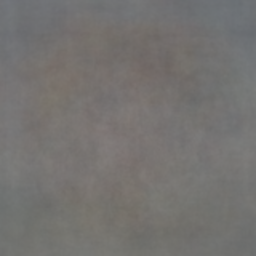

/home/gustav/opgaver/old/bachelor/ds_proc/EuroSAT


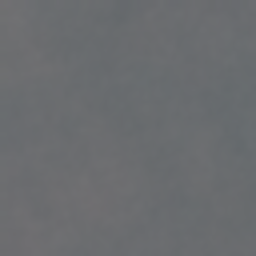

/home/gustav/opgaver/old/bachelor/ds_proc/celeba_hq_256


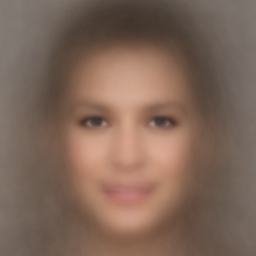

In [37]:
for b, p in enumerate([a_path,b_path,c_path]):
    print(p)
    files = np.array(findAllFiles(p))
    n = len(files)
    n_files = 300
    subset_idx = np.random.choice(np.random.randint(0, n), n_files, replace=False)
    r2 = np.zeros((256,256,3), dtype=np.uint64)
    for i, f_path in enumerate(files[subset_idx]):
        img = Image.open(f_path).convert("RGB")
        w, h = img.size
        a = min(w,h)
        #print(w,h,a,((w-a)//2, (h-a)//2, a+((w-a)//2),a+((h-a)//2)))
        img = img.crop(((w-a)//2, (h-a)//2, a+((w-a)//2),a+((h-a)//2)))
        img = img.resize((256,256))
        r2 += np.array(img)
    r2 = r2.astype(np.float64) / n_files
    display(Image.fromarray(r2.astype(np.uint8)))

In [57]:
def img_max_min(p):
    img = np.array(Image.open(f_path).convert("RGB"))
    return img.max(), img.min()

for b, p in enumerate([a_path,b_path,c_path]):
    files = np.array(findAllFiles(p))
    mm = np.array([img_max_min(p) for p in files])
    mean = ((mm.T[0] > (255*.9)) * (mm.T[1] < (225*.1))).mean()
    print(mean)

1.0
1.0
1.0


In [38]:
n_files = 51

na_rgb = np.zeros((n_files,3))
a_rgb  = np.zeros((n_files,3))

for n in range(n_files):
    img_na = Image.open(Path(f"/home/gustav/Pictures/white-bal/{n}.tiff"))
    img_a  = Image.open(Path(f"/home/gustav/Pictures/white-bal/a{n}.tiff"))

    na_rgb[n] = np.array(img_na).mean(axis=(0,1)) / 255
    a_rgb [n] = np.array(img_a) .mean(axis=(0,1)) / 255

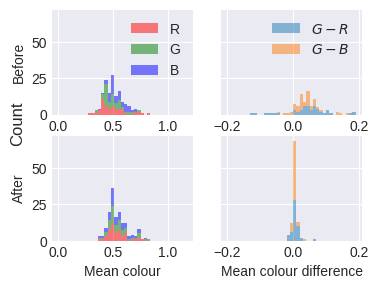

In [444]:
fig, ax = plt.subplots(2,2, sharey=True)
fig.set_size_inches(4, 3)

bins = [i*.03 for i in range(40)]

ax[0,0].hist(na_rgb, alpha=.5, bins=bins, stacked=True, color=["r","g","b"])
ax[0,0].set_ylabel("Before")
ax[1,0].hist(a_rgb,  alpha=.5, bins=bins, stacked=True, color=["r","g","b"])
ax[1,0].set_ylabel("After")
ax[1,0].set_xlabel("Mean colour")
ax[0,0].legend(["R", "G", "B"])

bins = [-.2 + i*.01 for i in range(40)]

r, b, g = na_rgb.T
ax[0,1].hist([g-r,g-b], bins=bins, alpha=.5, stacked=True)

r, b, g = a_rgb.T
ax[1,1].hist([g-r,g-b], bins=bins, alpha=.5, stacked=True)

ax[1,1].set_xlabel("Mean colour difference")
ax[0,1].legend(["$G-R$", "$G-B$"])
syl = fig.supylabel("Count")
plt.show()

0.7290291287204641


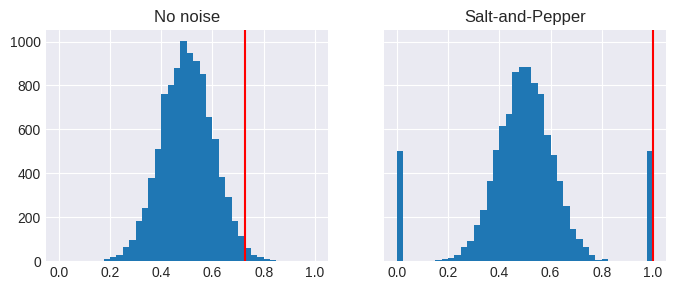

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(8,3)
x = np.random.normal(.5,.1,size=10000)
p = np.percentile(x, 99)
print(p)
ax[0].hist(x, bins=[i*.025 for i in range(41)])
ax[0].axline((p, 0), (p, 1000), color="red")
ax[0].set_title("No noise")
x = np.concatenate((np.random.normal(.5,.1,size=9000),np.zeros(500),np.ones(500)))
ax[1].hist(x, bins=[i*.025 for i in range(41)])
p = np.percentile(x, 99)
ax[1].axline((p, 0), (p, 1000), color="red")
ax[1].set_title("Salt-and-Pepper")
plt.show()

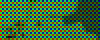

In [108]:
import cfa
img = cfa.colorize_cfa(cfa.rgb_to_cfa(np.array(Image.open("/home/gustav/Pictures/flower.png")), cfa.rgb_kf), cfa.rgb_kf)
img = img[90:110,50:100]
Image.fromarray(img).resize((100, 40), Image.Resampling.NEAREST)